# Part 1: Data preparation

We'll try to figure out whether there is a systematic relationship between elevated urban air temperatures and population density based on an archive of weather station data from [NOAA's GHCN](https://www.ncdc.noaa.gov/data-access/land-based-station-data/land-based-datasets/global-historical-climatology-network-ghcn) and population data from the [GHSL](https://ghsl.jrc.ec.europa.eu/). 

This notebook prepares the station data by joining information about population numbers at different points in time, region, climate zone, and nearest neighbor station to it.


# ⚠ 

Some parts of this analysis take quite a while. Look for the fields marked with a 

# 🏁

these indicate where intermediate results have been stored and can simply be re-used instead of running the analysis again.

Import some libraries we'll use:


In [6]:
import urllib.request
import gzip
import zipfile
import pandas as pd
import geopandas as gpd
import os
from scipy import stats
import matplotlib.pyplot as plt
import rasterio as rio
import numpy as np
from pyproj import Proj, transform
from scipy.spatial import cKDTree  
from scipy import stats
from shapely.geometry import Point
import urllib.request
from rasterstats import zonal_stats

from sklearn import linear_model

%matplotlib inline
plt.rcParams['figure.figsize'] = (14.0, 10.0) # larger plots

# Get NOAA weather stations

First, let's get the [list of NOAA weather stations](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt) so that we have a lat/lon location for each:

🏁

In [4]:
file = 'ghcnd-stations.txt'

if os.path.isfile(file):
    print('Stations already downloaded, using local file.')
else:
    print('Using online stations file directly.')
    file = 'https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt'

# we are using 100000 rows here to let pandas figure out the column widths - this is a bit slower, 
# but makes sure that we get all the stations way out west or south correctly without chopping of the minus sign 
stations = pd.read_fwf(file, 
            infer_nrows=100000, # how many rows to use to infer the column widths
            usecols = [0,1,2,3,5],
            names = ["station", "lat", "lon", "elevation", "name"])

stations.head()

Using online stations file directly.


,station,lat,lon,elevation,name
0,ACW00011604,17.1167,-61.7833,10.1,ST JOHNS COOLIDGE FLD
1,ACW00011647,17.1333,-61.7833,19.2,ST JOHNS
2,AE000041196,25.3330,55.5170,34.0,SHARJAH INTER. AIRP
3,AEM00041194,25.2550,55.3640,10.4,DUBAI INTL
4,AEM00041217,24.4330,54.6510,26.8,ABU DHABI INTL


Check the range of the lat and lon columns to make sure the coordinates have been parsed correctly:

In [5]:
print(f'Lats go from {stations.lat.min()} to {stations.lat.max()}')
print(f'Lons go from {stations.lon.min()} to {stations.lon.max()}')

Lats go from -90.0 to 83.65
Lons go from -179.983 to 179.32


Pull out the country ID from the station column (first two letters):

In [6]:
stations["country"] = stations["station"].astype(str).str[0:2]
stations.head()

,station,lat,lon,elevation,name,country
0,ACW00011604,17.1167,-61.7833,10.1,ST JOHNS COOLIDGE FLD,AC
1,ACW00011647,17.1333,-61.7833,19.2,ST JOHNS,AC
2,AE000041196,25.3330,55.5170,34.0,SHARJAH INTER. AIRP,AE
3,AEM00041194,25.2550,55.3640,10.4,DUBAI INTL,AE
4,AEM00041217,24.4330,54.6510,26.8,ABU DHABI INTL,AE


Since the GHSL data we'll be using later is in Mollweide projection, we'll need to [project](https://github.com/pyproj4/pyproj) the lat/lon to the World Mollweide projection that the raster uses and pick up the values at those projected coordinates:

🏁

In [7]:
file = 'stations_moll.csv'

if os.path.isfile(file):
    print('Stations already projected to Mollweide, using local file.')
    stations = pd.read_csv(file, index_col=0)
else:
    inProj = Proj(init='epsg:4326')   # lat/lon 
    outProj = Proj('+proj=moll +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs', preserve_flags=True) # Mollweide

    projectedLocations = []

    # go through the list of stations and project each one to Mollweide
    for index, station in stations.iterrows():
        projectedLocations.append((transform(inProj,outProj,station['lon'],station['lat'])))

    # add the projected coordinates back to the stations dataframe
    stations['mollX'], stations['mollY'] = zip(*projectedLocations)  # 'unzip' with the *
    stations.to_csv(file)


stations.head()

/Users/carsten/miniconda3/envs/UHI-NOAA/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/carsten/miniconda3/envs/UHI-NOAA/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


,station,lat,lon,elevation,name,country,mollX,mollY
0,ACW00011604,17.1167,-61.7833,10.1,ST JOHNS COOLIDGE FLD,AC,-6.021233e+06,2.104299e+06
1,ACW00011647,17.1333,-61.7833,19.2,ST JOHNS,AC,-6.020901e+06,2.106316e+06
2,AE000041196,25.3330,55.5170,34.0,SHARJAH INTER. AIRP,AE,5.226731e+06,3.092960e+06
3,AEM00041194,25.2550,55.3640,10.4,DUBAI INTL,AE,5.214407e+06,3.083680e+06
4,AEM00041217,24.4330,54.6510,26.8,ABU DHABI INTL,AE,5.168502e+06,2.985740e+06


# Spatial Index

Next, we'll build a spatial index of the stations, so we can quickly look up the nearest neighbors of any station. We'll be using the [scipy.spatial.cKDTree](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.query.html) (based on [this hint](https://gis.stackexchange.com/a/301935/33224).). For that, we'll pull out just the Mollweide coordinates and build the index based on those (otherwise SciPy will make a multidimensional index using all columns):

In [8]:
stationsIndex = cKDTree(stations[['mollX','mollY']].values)

Let's try to find the closest stations to a specific one by name:

In [9]:
def queryStation(stationID, stations, stationsIndex, k=1):
    queryCoords = stations[stations.station==stationID][['mollX','mollY']].values
    dd, ii = stationsIndex.query(queryCoords, 
                             k=range(2,2+k), # start at 2, otherwise we get the station itself as first result
                             n_jobs=-1,      # use all CPUs
                             p=2   )         # p-norm 2 = euclidian distance
    
    knn = stations.iloc[ii[0]]
    knn = knn.copy()  # otherwise we might be modifying the stations dataframe...
    knn['distance'] = dd[0]
    return knn

Test:

In [10]:
stationID = 'RQC00663871'   # GARZAS station
queryStation(stationID, stations, stationsIndex, k=5)

,station,lat,lon,elevation,name,country,mollX,mollY,distance
47281,RQC00660053,18.1614,-66.7222,506.0,ADJUNTAS 1 S,RQ,-6.479289e+06,2.231113e+06,1924.820868
47406,RQC00668684,18.1333,-66.7333,868.7,SALTILLO 2 ADJUNTAS,RQ,-6.481011e+06,2.227706e+06,2060.888936
47341,RQC00664614,18.1506,-66.7719,2.7,HUMACAO NATURAL RESERVE,RQ,-6.484363e+06,2.229804e+06,3735.475164
47282,RQC00660061,18.1747,-66.7978,557.8,ADJUNTAS SUBSTN,RQ,-6.486324e+06,2.232726e+06,6435.610695
47384,RQC00666982,18.0833,-66.7333,349.9,PENUELAS SALTO GARZAS,RQ,-6.482155e+06,2.221642e+06,8231.252200


# Get [GHSL population data](https://ghsl.jrc.ec.europa.eu/ghs_pop.php) for 2015

Download dir at http://cidportal.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_POP_GPW4_GLOBE_R2015A/

At this point, we only use this dataset to make sure we only keep stations for which we actually have population data, and get rid of those in the far North and South (they are quite unlikely to experience UHI anyway... 🥶)

🏁

In [11]:
file = 'GHS_POP_GPW42015_GLOBE_R2015A_54009_250_v1_0/GHS_POP_GPW42015_GLOBE_R2015A_54009_250_v1_0.tif'
file_zip = 'GHS_POP_GPW42015_GLOBE_R2015A_54009_250_v1_0.zip'

if os.path.isfile(file):
    print('GHSL population data for 2015 already downloaded.')
else:
    print('Downloading data...')
    url = 'http://cidportal.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_POP_GPW4_GLOBE_R2015A/GHS_POP_GPW42015_GLOBE_R2015A_54009_250/V1-0/GHS_POP_GPW42015_GLOBE_R2015A_54009_250_v1_0.zip'
    urllib.request.urlretrieve(url, file_zip)

    print('Unzipping...')
    zip_ref = zipfile.ZipFile(file_zip, 'r')
    zip_ref.extractall('.')
    zip_ref.close()

    print('Cleaning up...')    
    # remove the ZIP file and the extracted overview file - we don't need it and the .ovr file is huge (3GB!)
    os.remove(file_zip)
    os.remove('GHS_POP_GPW42015_GLOBE_R2015A_54009_250_v1_0/GHS_POP_GPW42015_GLOBE_R2015A_54009_250_v1_0.tif.ovr')
    print('Done.')

Unzipping...
Cleaning up...
Done.


We'll use the data to assign each station an estimate of the population density in the GHSL cell that it is in. Since GHSL is in an equal area projection (i.e. all cells have the same area), we can safely do that.

We'll use [rasterio's sample method](https://gis.stackexchange.com/questions/190423/getting-pixel-values-at-single-point-using-rasterio) for that. Let's read in the GeoTIFF first:

In [12]:
pop2015 = rio.open(file)
pop2015

<open DatasetReader name='GHS_POP_GPW42015_GLOBE_R2015A_54009_250_v1_0/GHS_POP_GPW42015_GLOBE_R2015A_54009_250_v1_0.tif' mode='r'>

Check that all coordinates are in the raster's bounding box:

In [13]:
print(min(stations['mollX']) > pop2015.bounds.left)
print(max(stations['mollX']) < pop2015.bounds.right)

print(min(stations['mollY']) > pop2015.bounds.bottom)
print(max(stations['mollY']) < pop2015.bounds.top)

True
True
False
False


Okay, so there are some stations North and South of our raster. Remove the stations that are outside of our raster bounding box (they are not really useful for our UHI analysis anyway, and [rasterio seems trip over them](https://gis.stackexchange.com/questions/323481/error-using-rasterios-sample-method)):

In [14]:
print(f'Before removal: {len(stations.index)} stations.')
stations = stations.drop(stations[stations['mollY'] < pop2015.bounds.bottom].index)
stations = stations.drop(stations[stations['mollY'] > pop2015.bounds.top].index)
print(f'After removal: {len(stations.index)} stations.')

Before removal: 115082 stations.
After removal: 114979 stations.


Save to a CSV file again and re-build the spatial index, now that we have removed some stations:

In [15]:
stations.to_csv('stations_moll_inraster.csv')
stationsIndex = cKDTree(stations[['mollX','mollY']].values)

Now we can use those remaining station locations to sample the raster and add a column with the population density in 2015:

🏁

In [16]:
file = 'stations_moll_inraster_pop2015.csv'

if os.path.isfile(file):
    print('Stations data with 2015 population already generated; reusing existing file.')
    stations = pd.read_csv(file, index_col=0)
else:

    locations = list(zip(stations['mollX'], stations['mollY']))
    pop2015col = []

    for val in pop2015.sample(locations):
        pop2015col.append(val[0])

    # make this list a new column in our stations dataframe
    stations['pop2015'] = pop2015col
    stations.to_csv(file)

stations.head()

,station,lat,lon,elevation,name,country,mollX,mollY,pop2015
0,ACW00011604,17.1167,-61.7833,10.1,ST JOHNS COOLIDGE FLD,AC,-6.021233e+06,2.104299e+06,0.000000
1,ACW00011647,17.1333,-61.7833,19.2,ST JOHNS,AC,-6.020901e+06,2.106316e+06,0.000000
2,AE000041196,25.3330,55.5170,34.0,SHARJAH INTER. AIRP,AE,5.226731e+06,3.092960e+06,0.000000
3,AEM00041194,25.2550,55.3640,10.4,DUBAI INTL,AE,5.214407e+06,3.083680e+06,103.520790
4,AEM00041217,24.4330,54.6510,26.8,ABU DHABI INTL,AE,5.168502e+06,2.985740e+06,180.376755


# Population 2000

Download and attach the population data for 2000 the same way as above:

In [17]:
file = 'GHS_POP_GPW42000_GLOBE_R2015A_54009_250_v1_0/GHS_POP_GPW42000_GLOBE_R2015A_54009_250_v1_0.tif'
file_zip = 'GHS_POP_GPW42000_GLOBE_R2015A_54009_250_v1_0.zip'

if os.path.isfile(file):
    print('GHSL population data for 2000 already downloaded.')
else:
    print('Downloading data...')
    url = 'http://cidportal.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_POP_GPW4_GLOBE_R2015A/GHS_POP_GPW42000_GLOBE_R2015A_54009_250/V1-0/GHS_POP_GPW42000_GLOBE_R2015A_54009_250_v1_0.zip'
    urllib.request.urlretrieve(url, file_zip)

    print('Unzipping...')
    zip_ref = zipfile.ZipFile(file_zip, 'r')
    zip_ref.extractall('.')
    zip_ref.close()

    print('Cleaning up...')    
    # remove the ZIP file and the extracted overview file - we don't need it and the .ovr file is huge (3GB!)
    os.remove(file_zip)
    os.remove('GHS_POP_GPW42000_GLOBE_R2015A_54009_250_v1_0/GHS_POP_GPW42000_GLOBE_R2015A_54009_250_v1_0.tif.ovr')
    print('Done.')

pop2000 = rio.open(file)

Unzipping...
Cleaning up...
Done.


In [18]:
file = 'stations_moll_inraster_pop2015_2000.csv'

if os.path.isfile(file):
    print('Stations data with 2015 and 2000 population already generated; reusing existing file.')
    stations = pd.read_csv(file, index_col=0)
else:

    locations = list(zip(stations['mollX'], stations['mollY']))
    pop2000col = []

    for val in pop2000.sample(locations):
        pop2000col.append(val[0])

    # make this list a new column in our stations dataframe
    stations['pop2000'] = pop2000col
    stations.to_csv(file)

stations.head()

,station,lat,lon,elevation,name,country,mollX,mollY,pop2015,pop2000
0,ACW00011604,17.1167,-61.7833,10.1,ST JOHNS COOLIDGE FLD,AC,-6.021233e+06,2.104299e+06,0.000000,0.000000
1,ACW00011647,17.1333,-61.7833,19.2,ST JOHNS,AC,-6.020901e+06,2.106316e+06,0.000000,0.000000
2,AE000041196,25.3330,55.5170,34.0,SHARJAH INTER. AIRP,AE,5.226731e+06,3.092960e+06,0.000000,0.000000
3,AEM00041194,25.2550,55.3640,10.4,DUBAI INTL,AE,5.214407e+06,3.083680e+06,103.520790,16.931656
4,AEM00041217,24.4330,54.6510,26.8,ABU DHABI INTL,AE,5.168502e+06,2.985740e+06,180.376755,84.788246


# Population 1990

Rinse and repeat...

In [19]:
file = 'GHS_POP_GPW41990_GLOBE_R2015A_54009_250_v1_0/GHS_POP_GPW41990_GLOBE_R2015A_54009_250_v1_0.tif'
file_zip = 'GHS_POP_GPW41990_GLOBE_R2015A_54009_250_v1_0.zip'

if os.path.isfile(file):
    print('GHSL population data for 1990 already downloaded.')
else:
    print('Downloading data...')
    url = 'http://cidportal.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_POP_GPW4_GLOBE_R2015A/GHS_POP_GPW41990_GLOBE_R2015A_54009_250/V1-0/GHS_POP_GPW41990_GLOBE_R2015A_54009_250_v1_0.zip'
    urllib.request.urlretrieve(url, file_zip)

    print('Unzipping...')
    zip_ref = zipfile.ZipFile(file_zip, 'r')
    zip_ref.extractall('.')
    zip_ref.close()

    print('Cleaning up...')    
    # remove the ZIP file and the extracted overview file - we don't need it and the .ovr file is huge (3GB!)
    os.remove(file_zip)
    os.remove('GHS_POP_GPW41990_GLOBE_R2015A_54009_250_v1_0/GHS_POP_GPW41990_GLOBE_R2015A_54009_250_v1_0.tif.ovr')
    print('Done.')

pop1990 = rio.open(file)

Unzipping...
Cleaning up...
Done.


In [20]:
file = 'stations_moll_inraster_pop2015_2000_1990.csv'

if os.path.isfile(file):
    print('Stations data with 2015, 2000 and 1990 population already generated; reusing existing file.')
    stations = pd.read_csv(file, index_col=0)
else:

    locations = list(zip(stations['mollX'], stations['mollY']))
    pop1990col = []

    for val in pop1990.sample(locations):
        pop1990col.append(val[0])

    # make this list a new column in our stations dataframe
    stations['pop1990'] = pop1990col
    stations.to_csv(file)

stations.head(15)

,station,lat,lon,elevation,name,country,mollX,mollY,pop2015,pop2000,pop1990
0,ACW00011604,17.1167,-61.7833,10.1,ST JOHNS COOLIDGE FLD,AC,-6.021233e+06,2.104299e+06,0.000000,0.000000,0.000000
1,ACW00011647,17.1333,-61.7833,19.2,ST JOHNS,AC,-6.020901e+06,2.106316e+06,0.000000,0.000000,0.000000
2,AE000041196,25.3330,55.5170,34.0,SHARJAH INTER. AIRP,AE,5.226731e+06,3.092960e+06,0.000000,0.000000,0.000000
3,AEM00041194,25.2550,55.3640,10.4,DUBAI INTL,AE,5.214407e+06,3.083680e+06,103.520790,16.931656,9.649481
4,AEM00041217,24.4330,54.6510,26.8,ABU DHABI INTL,AE,5.168502e+06,2.985740e+06,180.376755,84.788246,54.742096
5,AEM00041218,24.2620,55.6090,264.9,AL AIN INTL,AE,5.263508e+06,2.965335e+06,0.000000,0.000000,0.000000
6,AF000040930,35.3170,69.0170,3366.0,NORTH-SALANG,AF,6.097232e+06,4.259532e+06,0.000000,0.000000,0.000000
7,AFM00040938,34.2100,62.2280,977.2,HERAT,AF,5.543622e+06,4.132507e+06,21.793083,0.000000,0.000000
8,AFM00040948,34.5660,69.2120,1791.3,KABUL INTL,AF,6.149475e+06,4.173426e+06,0.000000,0.000000,0.000000
9,AFM00040990,31.5000,65.8500,1010.0,KANDAHAR AIRPORT,AF,5.978977e+06,3.818927e+06,0.000000,0.000000,0.000000


# Population 1975

One more time... [🤖](https://www.youtube.com/watch?v=FGBhQbmPwH8)

In [21]:
file = 'GHS_POP_GPW41975_GLOBE_R2015A_54009_250_v1_0/GHS_POP_GPW41975_GLOBE_R2015A_54009_250_v1_0.tif'
file_zip = 'GHS_POP_GPW41975_GLOBE_R2015A_54009_250_v1_0.zip'

if os.path.isfile(file):
    print('GHSL population data for 1975 already downloaded.')
else:
    print('Downloading data...')
    url = 'http://cidportal.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_POP_GPW4_GLOBE_R2015A/GHS_POP_GPW41975_GLOBE_R2015A_54009_250/V1-0/GHS_POP_GPW41975_GLOBE_R2015A_54009_250_v1_0.zip'
    urllib.request.urlretrieve(url, file_zip)

    print('Unzipping...')
    zip_ref = zipfile.ZipFile(file_zip, 'r')
    zip_ref.extractall('.')
    zip_ref.close()

    print('Cleaning up...')    
    # remove the ZIP file and the extracted overview file - we don't need it and the .ovr file is huge (3GB!)
    os.remove(file_zip)
    os.remove('GHS_POP_GPW41975_GLOBE_R2015A_54009_250_v1_0/GHS_POP_GPW41975_GLOBE_R2015A_54009_250_v1_0.tif.ovr')
    print('Done.')

pop1975 = rio.open(file)

Unzipping...
Cleaning up...
Done.


In [22]:
file = 'stations_moll_inraster_pop2015_2000_1990_1975.csv'

if os.path.isfile(file):
    print('Stations data with 2015, 2000, 1990 and 1975 population already generated; reusing existing file.')
    stations = pd.read_csv(file, index_col=0)
else:

    locations = list(zip(stations['mollX'], stations['mollY']))
    pop1975col = []

    for val in pop1975.sample(locations):
        pop1975col.append(val[0])

    # make this list a new column in our stations dataframe
    stations['pop1975'] = pop1975col
    stations.to_csv(file)

stations.head(15)

,station,lat,lon,elevation,name,country,mollX,mollY,pop2015,pop2000,pop1990,pop1975
0,ACW00011604,17.1167,-61.7833,10.1,ST JOHNS COOLIDGE FLD,AC,-6.021233e+06,2.104299e+06,0.000000,0.000000,0.000000,0.000000
1,ACW00011647,17.1333,-61.7833,19.2,ST JOHNS,AC,-6.020901e+06,2.106316e+06,0.000000,0.000000,0.000000,0.000000
2,AE000041196,25.3330,55.5170,34.0,SHARJAH INTER. AIRP,AE,5.226731e+06,3.092960e+06,0.000000,0.000000,0.000000,0.000000
3,AEM00041194,25.2550,55.3640,10.4,DUBAI INTL,AE,5.214407e+06,3.083680e+06,103.520790,16.931656,9.649481,2.571450
4,AEM00041217,24.4330,54.6510,26.8,ABU DHABI INTL,AE,5.168502e+06,2.985740e+06,180.376755,84.788246,54.742096,21.834427
5,AEM00041218,24.2620,55.6090,264.9,AL AIN INTL,AE,5.263508e+06,2.965335e+06,0.000000,0.000000,0.000000,0.000000
6,AF000040930,35.3170,69.0170,3366.0,NORTH-SALANG,AF,6.097232e+06,4.259532e+06,0.000000,0.000000,0.000000,0.000000
7,AFM00040938,34.2100,62.2280,977.2,HERAT,AF,5.543622e+06,4.132507e+06,21.793083,0.000000,0.000000,0.000000
8,AFM00040948,34.5660,69.2120,1791.3,KABUL INTL,AF,6.149475e+06,4.173426e+06,0.000000,0.000000,0.000000,0.000000
9,AFM00040990,31.5000,65.8500,1010.0,KANDAHAR AIRPORT,AF,5.978977e+06,3.818927e+06,0.000000,0.000000,0.000000,0.000000


## Population densities

The cells in our population dataset are only [250x250m](https://ghsl.jrc.ec.europa.eu/ghs_pop2019.php), so to get population per km<sup>2</sup>, we actually have to multiply the number with 16 (just to make it a bit easier to compare to common measures of population density in people per km<sup>2</sup>:

In [23]:
stations["popdens2015"] = stations["pop2015"] * 16
stations["popdens2000"] = stations["pop2000"] * 16
stations["popdens1990"] = stations["pop1990"] * 16
stations["popdens1975"] = stations["pop1975"] * 16

stations.head()

,station,lat,lon,elevation,name,country,mollX,mollY,pop2015,pop2000,pop1990,pop1975,popdens2015,popdens2000,popdens1990,popdens1975
0,ACW00011604,17.1167,-61.7833,10.1,ST JOHNS COOLIDGE FLD,AC,-6.021233e+06,2.104299e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,ACW00011647,17.1333,-61.7833,19.2,ST JOHNS,AC,-6.020901e+06,2.106316e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,AE000041196,25.3330,55.5170,34.0,SHARJAH INTER. AIRP,AE,5.226731e+06,3.092960e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,AEM00041194,25.2550,55.3640,10.4,DUBAI INTL,AE,5.214407e+06,3.083680e+06,103.520790,16.931656,9.649481,2.571450,1656.332642,270.906494,154.391693,41.143192
4,AEM00041217,24.4330,54.6510,26.8,ABU DHABI INTL,AE,5.168502e+06,2.985740e+06,180.376755,84.788246,54.742096,21.834427,2886.028076,1356.611938,875.873535,349.350830


### Comparisons with nearest neighbor

Let's find the closest neighbor for each station, so that we can later calculate differences in population density (for each year), elevation, and latitutde between nearest neighbor stations:

In [24]:
# add new columns to hold the ID of the nearest station and the distance to it

stations["NN"] = ""
stations["NN_dist"] = ""
stations["NN_elev"] = ""
stations["NN_lat"] = ""
stations["NN_popdens2015"] = ""
stations["NN_popdens2000"] = ""
stations["NN_popdens1990"] = ""
stations["NN_popdens1975"] = ""
stations["NN_lat_diff"] = ""
stations["NN_popdens2015_diff"] = ""
stations["NN_popdens2000_diff"] = ""
stations["NN_popdens1990_diff"] = ""
stations["NN_popdens1975_diff"] = ""

stations.head()

,station,lat,lon,elevation,name,country,mollX,mollY,pop2015,pop2000,...,NN_lat,NN_popdens2015,NN_popdens2000,NN_popdens1990,NN_popdens1975,NN_lat_diff,NN_popdens2015_diff,NN_popdens2000_diff,NN_popdens1990_diff,NN_popdens1975_diff
0,ACW00011604,17.1167,-61.7833,10.1,ST JOHNS COOLIDGE FLD,AC,-6.021233e+06,2.104299e+06,0.000000,0.000000,...,,,,,,,,,,
1,ACW00011647,17.1333,-61.7833,19.2,ST JOHNS,AC,-6.020901e+06,2.106316e+06,0.000000,0.000000,...,,,,,,,,,,
2,AE000041196,25.3330,55.5170,34.0,SHARJAH INTER. AIRP,AE,5.226731e+06,3.092960e+06,0.000000,0.000000,...,,,,,,,,,,
3,AEM00041194,25.2550,55.3640,10.4,DUBAI INTL,AE,5.214407e+06,3.083680e+06,103.520790,16.931656,...,,,,,,,,,,
4,AEM00041217,24.4330,54.6510,26.8,ABU DHABI INTL,AE,5.168502e+06,2.985740e+06,180.376755,84.788246,...,,,,,,,,,,


Iterate through the DF and fill these columns row by row. 

🔥 **TODO** This is reeeeally slow, I'm sure there must be a faster way to do this... for now, I'm at least making sure we only need to do this once by saving the results in a CSV that can just be loaded again

🏁

In [25]:
file = 'stations_with_nearest_neighbor_data.csv'

if os.path.isfile(file):
    print('Nearest neighbor data already computed, using local file.')
    stations = pd.read_csv(file, index_col=0)
else:
    # nearest neighbor station:    
    for index, row in stations.iterrows():
        s = row['station']
        
        # look up nearest neighbor station
        nn = queryStation(s, stations, stationsIndex)
                    
        # pick up values from nearest neighbor station
        stations.loc[stations.station == s, 'NN']      = nn['station'].iloc[0]
        stations.loc[stations.station == s, 'NN_dist'] = nn['distance'].iloc[0]        
        stations.loc[stations.station == s, 'NN_elev'] = nn['elevation'].iloc[0]
        stations.loc[stations.station == s, 'NN_lat']  = nn['lat'].iloc[0]
        
        stations.loc[stations.station == s, 'NN_popdens2015'] = nn['popdens2015'].iloc[0]
        stations.loc[stations.station == s, 'NN_popdens2000'] = nn['popdens2000'].iloc[0]
        stations.loc[stations.station == s, 'NN_popdens1990'] = nn['popdens1990'].iloc[0]
        stations.loc[stations.station == s, 'NN_popdens1975'] = nn['popdens1975'].iloc[0]

# calculate differences between station and nearest neighbor
stations["NN_lat_diff"]         = stations["lat"] - stations["NN_lat"]
stations["NN_popdens2015_diff"] = stations["popdens2015"] - stations["NN_popdens2015"]
stations["NN_popdens2000_diff"] = stations["popdens2000"] - stations["NN_popdens2000"]
stations["NN_popdens1990_diff"] = stations["popdens1990"] - stations["NN_popdens1990"]
stations["NN_popdens1975_diff"] = stations["popdens1975"] - stations["NN_popdens1975"]
                
stations.to_csv(file)
        
stations.head()

,station,lat,lon,elevation,name,country,mollX,mollY,pop2015,pop2000,...,NN_lat,NN_popdens2015,NN_popdens2000,NN_popdens1990,NN_popdens1975,NN_lat_diff,NN_popdens2015_diff,NN_popdens2000_diff,NN_popdens1990_diff,NN_popdens1975_diff
0,ACW00011604,17.1167,-61.7833,10.1,ST JOHNS COOLIDGE FLD,AC,-6.021233e+06,2.104299e+06,0.000000,0.000000,...,17.1333,0,0,0,0,-0.0166,0,0,0,0
1,ACW00011647,17.1333,-61.7833,19.2,ST JOHNS,AC,-6.020901e+06,2.106316e+06,0.000000,0.000000,...,17.1167,0,0,0,0,0.0166,0,0,0,0
2,AE000041196,25.3330,55.5170,34.0,SHARJAH INTER. AIRP,AE,5.226731e+06,3.092960e+06,0.000000,0.000000,...,25.255,1656.33,270.906,154.392,41.1432,0.078,-1656.33,-270.906,-154.392,-41.1432
3,AEM00041194,25.2550,55.3640,10.4,DUBAI INTL,AE,5.214407e+06,3.083680e+06,103.520790,16.931656,...,25.333,0,0,0,0,-0.078,1656.33,270.906,154.392,41.1432
4,AEM00041217,24.4330,54.6510,26.8,ABU DHABI INTL,AE,5.168502e+06,2.985740e+06,180.376755,84.788246,...,24.262,0,0,0,0,0.171,2886.03,1356.61,875.874,349.351


In [26]:
stations.head(15)[['station','NN','NN_dist']]

,station,NN,NN_dist
0,ACW00011604,ACW00011647,2044.42
1,ACW00011647,ACW00011604,2044.42
2,AE000041196,AEM00041194,15427.6
3,AEM00041194,AE000041196,15427.6
4,AEM00041217,AEM00041218,97173
5,AEM00041218,MUM00041244,17560.4
6,AF000040930,AFM00040948,100714
7,AFM00040938,TX000038987,127736
8,AFM00040948,AF000040930,100714
9,AFM00040990,PKM00041660,207877


While working with the data, I saw that some stations are missing elevation information (marked with `-999.9`), which we will be using later:

In [27]:
print(str(len(stations[stations.elevation == -999.9])),'out of',str(len(stations)),'lack elevation data.')

4620 out of 114979 lack elevation data.


A small percentage, but let's still fix that. We'll use [GPS Visualizer's lookup service for that](https://www.gpsvisualizer.com/elevation). The API is not documented, but this was quite easy to figure out and saves us downloading gigabytes of data for the underlying [SRTM data](https://www2.jpl.nasa.gov/srtm/): 

In [28]:
def elevation_lookup(lat, lon):
    url = 'https://www.gpsvisualizer.com/elevation_data/elev2018.js?coords='+str(lat)+'%2C'+str(lon)+'&gv_nocache=1563196454722'

    with urllib.request.urlopen(url) as f:
        response = f.read(100).decode('utf-8')
        ele = response.split("(")[1].split(",")[0]
        if ele == 'null':
            return 0.0
        
        number = float(ele)
        if number == 0.0:
            return number
        
        return (1./number) # I don't know if this is some kind of super-cheap encryption they do to make it harder to use their API, but they do the same operation and the output make sense

    

Loop through the rows with missing stations and look up the elevation at that lat/lon position using our function. This is going to take a while for ~4000 stations without elevation 😴

🏁

In [30]:
file = 'stations_with_nearest_neighbor_data_fixed_elevation.csv'

if os.path.isfile(file):
    print('Elevation already looked up, using local file.')
    stations = pd.read_csv(file, index_col=0)
else:
    for index, row in stations[stations.elevation == -999.9].iterrows():
        new_elev = elevation_lookup(row.lat, row.lon)
        #print(new_elev)
        stations.loc[stations.station == row.station, 'elevation']  = new_elev
    
    # recalculate elevation difference
    stations['nn_elev_diff'] = stations['elevation'] - stations['NN_elev']
        
    stations.to_csv(file)
    print('Done looking up elevation values.')


Done looking up elevation values.


Next, we will calculate the difference in latitude and poulation density for the four periods between the a given station and its nearest neighbor:

In [31]:
file = 'stations_with_nearest_neighbor_data_differences.csv'

if os.path.isfile(file):
    print('Differences already calculated, using local file.')
    stations = pd.read_csv(file, index_col=0)
else:
    stations['nn_popdens2015_diff'] = stations['popdens2015'] - stations['NN_popdens2015']
    stations['nn_popdens2000_diff'] = stations['popdens2000'] - stations['NN_popdens2000']
    stations['nn_popdens1990_diff'] = stations['popdens1990'] - stations['NN_popdens1990']
    stations['nn_popdens1975_diff'] = stations['popdens1975'] - stations['NN_popdens1975']
    stations['nn_lat_diff'] = stations['lat'] - stations['NN_lat']
    
    stations.to_csv(file)

    
stations.head(15)[['station',
                   'NN',
                   'NN_dist',
                   'nn_popdens2015_diff',
                   'nn_popdens2000_diff',
                   'nn_popdens1990_diff',
                   'nn_popdens1975_diff',
                   'nn_lat_diff']]

,station,NN,NN_dist,nn_popdens2015_diff,nn_popdens2000_diff,nn_popdens1990_diff,nn_popdens1975_diff,nn_lat_diff
0,ACW00011604,ACW00011647,2044.42,0,0,0,0,-0.0166
1,ACW00011647,ACW00011604,2044.42,0,0,0,0,0.0166
2,AE000041196,AEM00041194,15427.6,-1656.33,-270.906,-154.392,-41.1432,0.078
3,AEM00041194,AE000041196,15427.6,1656.33,270.906,154.392,41.1432,-0.078
4,AEM00041217,AEM00041218,97173,2886.03,1356.61,875.874,349.351,0.171
5,AEM00041218,MUM00041244,17560.4,-211.781,-1238.91,-1645.24,-1309.41,0.029
6,AF000040930,AFM00040948,100714,0,0,0,0,0.751
7,AFM00040938,TX000038987,127736,348.689,-4691.43,-1062.29,0,-1.0731
8,AFM00040948,AF000040930,100714,0,0,0,0,-0.751
9,AFM00040990,PKM00041660,207877,0,0,0,0,1.249


# Climate Zones

Now we'll add information about the climate zone each station is in, using these [world maps of the Köppen-Geiger Climate Classification](http://koeppen-geiger.vu-wien.ac.at/present.htm).

In [34]:
file = 'Map_KG-Global/KG_1986-2010.grd'
file_zip = 'Map_KG-Global.zip'

if os.path.isfile(file):
    print('Climate zones already downloaded.')
else:
    print('Downloading data...')
    url = 'http://koeppen-geiger.vu-wien.ac.at/Rcode/Map_KG-Global.zip'
    urllib.request.urlretrieve(url, file_zip)

    print('Unzipping...')
    zip_ref = zipfile.ZipFile(file_zip, 'r')
    zip_ref.extractall('.')
    zip_ref.close()

    print('Cleaning up...')    
    # remove the ZIP file and the extracted overview file - we don't need it and the .ovr file is huge (3GB!)
    os.remove(file_zip)
    print('Done.')

Climate zones already downloaded.


In [35]:
climateZones = rio.open(file)
climateZones

<open DatasetReader name='Map_KG-Global/KG_1986-2010.grd' mode='r'>

In [36]:
file = 'stations_with_climate_zones.csv'


if os.path.isfile(file):
    print('Climate zones already attached, using local file.')
    stations = pd.read_csv(file, index_col=0)
else:
    locations = list(zip(stations['lon'], stations['lat']))
    zones = []

    for val in climateZones.sample(locations):
        zones.append(val[0])

    # make this list a new column in our stations dataframe
    stations['climatezone'] = zones
    stations.to_csv(file)

stations.head()

,station,lat,lon,elevation,name,country,mollX,mollY,pop2015,pop2000,...,NN_popdens2000_diff,NN_popdens1990_diff,NN_popdens1975_diff,nn_elev_diff,nn_popdens2015_diff,nn_popdens2000_diff,nn_popdens1990_diff,nn_popdens1975_diff,nn_lat_diff,climatezone
0,ACW00011604,17.1167,-61.7833,10.1,ST JOHNS COOLIDGE FLD,AC,-6.021233e+06,2.104299e+06,0.000000,0.000000,...,0,0,0,-9.1,0,0,0,0,-0.0166,2
1,ACW00011647,17.1333,-61.7833,19.2,ST JOHNS,AC,-6.020901e+06,2.106316e+06,0.000000,0.000000,...,0,0,0,9.1,0,0,0,0,0.0166,2
2,AE000041196,25.3330,55.5170,34.0,SHARJAH INTER. AIRP,AE,5.226731e+06,3.092960e+06,0.000000,0.000000,...,-270.906,-154.392,-41.1432,23.6,-1656.33,-270.906,-154.392,-41.1432,0.078,7
3,AEM00041194,25.2550,55.3640,10.4,DUBAI INTL,AE,5.214407e+06,3.083680e+06,103.520790,16.931656,...,270.906,154.392,41.1432,-23.6,1656.33,270.906,154.392,41.1432,-0.078,7
4,AEM00041217,24.4330,54.6510,26.8,ABU DHABI INTL,AE,5.168502e+06,2.985740e+06,180.376755,84.788246,...,1356.61,875.874,349.351,-238.1,2886.03,1356.61,875.874,349.351,0.171,7


# World regions

Next, we'll load a shapefile with world regions and spatially join that to our station points.

**TODO**: Add source for the regions file (ask Peter)

In [68]:
file = "stations_complete.csv"

if os.path.isfile(file):
    print('Regions already attached, using local file.')
    stations = pd.read_csv(file, index_col=0)
else:
    
    print('Loading regions...')
    regions = gpd.read_file("Regions/UN_Regional_Boundaries.shp", layer='UN_Regional_Boundaries')
    
    # assign the "real" region names instead of just numbers:
    regions['Region_Name'] = '-'
    regions.loc[regions['Region'] == 0, 'Region_Name'] = 'Antarctica'
    regions.loc[regions['Region'] == 150, 'Region_Name'] = 'Europe'
    regions.loc[regions['Region'] == 21, 'Region_Name'] = 'North America'
    regions.loc[regions['Region'] == 419, 'Region_Name'] = 'Latin America'
    regions.loc[regions['Region'] == 142, 'Region_Name'] = 'Asia'
    regions.loc[regions['Region'] == 2, 'Region_Name'] = 'Africa'
    regions.loc[regions['Region'] == 9, 'Region_Name'] = 'Oceania'
    
    print('Converting stations to geodataframe...')
    stations = gpd.GeoDataFrame(stations, 
                 crs={'init': 'epsg:4326'}, 
                 geometry=[Point(xy) for xy in zip(stations.lon, stations.lat)])

    print('Spatial join...')
    stations = gpd.sjoin(stations, regions)
    stations.plot(column='Region_Name')
    
    # remove some columns we dont need
    stations.drop(['index_right', 'Region'], axis=1, inplace=True)
    stations.to_csv(file)

stations.head(5)

Regions already attached, using local file.


,station,lat,lon,elevation,name,country,mollX,mollY,pop2015,pop2000,...,NN_popdens1975_diff,nn_elev_diff,nn_popdens2015_diff,nn_popdens2000_diff,nn_popdens1990_diff,nn_popdens1975_diff,nn_lat_diff,climatezone,geometry,Region_Name
0,ACW00011604,17.1167,-61.7833,10.1,ST JOHNS COOLIDGE FLD,AC,-6.021233e+06,2.104299e+06,0.0,0.0,...,0.0,-9.1,0.0,0.0,0.0,0.0,-0.0166,2,POINT (-61.7833 17.1167),Latin America
1,ACW00011647,17.1333,-61.7833,19.2,ST JOHNS,AC,-6.020901e+06,2.106316e+06,0.0,0.0,...,0.0,9.1,0.0,0.0,0.0,0.0,0.0166,2,POINT (-61.7833 17.1333),Latin America
245,AR000000001,-29.6000,-58.1500,109.0,BAIBENE,AR,-5.344510e+06,-3.596996e+06,0.0,0.0,...,0.0,-1.0,0.0,0.0,0.0,0.0,-0.2300,9,POINT (-58.15 -29.6),Latin America
246,AR000000002,-29.8200,-57.4200,75.0,BONPLAND,AR,-5.270234e+06,-3.622776e+06,0.0,0.0,...,0.0,4.9,0.0,0.0,0.0,0.0,-0.1310,9,POINT (-57.42 -29.82),Latin America
247,AR000000003,-29.9800,-58.2800,90.0,CAZADORES CORRENTINOS,AR,-5.343830e+06,-3.641512e+06,0.0,0.0,...,0.0,7.0,0.0,0.0,0.0,0.0,0.0500,9,POINT (-58.28 -29.98),Latin America


Now we'll take this file and figure out which of the stations are within a tropical or subtropical [WUDAPT](http://www.wudapt.org) city, and which [LCZ](http://www.wudapt.org/lcz/) they are in:

# 🏁

In [7]:
file = 'stations_WUDAPT.csv'

if os.path.isfile(file):
    print('Stations data with WUDAPT LCZs already generated; reusing existing file.')
    stations = pd.read_csv(file, index_col=0)
else:
    print('Sampling all Wudapt cities')
    
    # open all WUDAPT cities in a list of rasters
    wudapt = []
    cities = []
    rasterdir = 'Cities_raster/cities_moll'
    for filename in os.listdir(rasterdir):
    # for filename in ['Phoenix.tif','Shanghai.tif']:    # 2 examples for testing:
        if filename.endswith('.tif'):
            wudapt.append(rio.open(rasterdir+'/'+filename))
            cities.append(filename[:-4]) # we'll make a column that stores the city name
    
    # add columns to the stations to hold the WUDAPT data
    stations['lcz'] = 'masked'
    stations['city'] = '-'
    
    stations.reset_index(inplace=True)
    
    # now loop through all station locations and look each one up in the rasters
    locations = list(zip(stations['mollX'], stations['mollY']))
    
    for dataset, city in (list(zip(wudapt, cities))):
        print(city)
        samples = pd.Series(dataset.sample(locations, masked=True))
        # now well'take those values and copy them over to the stations in the corresponding rows:

        samples.reset_index(drop=True,inplace=True)
        
        #print(samples[samples != 'masked'])
        stations.loc[samples != 'masked', 'lcz'] = samples[samples != 'masked']
        stations.loc[samples != 'masked', 'city'] = city
        

    stations[stations['lcz'] != 'masked'].to_csv(file)    

Stations data with WUDAPT LCZs already generated; reusing existing file.


How many stations are there in each WUDAPT city?

In [35]:
counts = stations[stations['city'] != '-']['city'].value_counts()
counts

Phoenix           358
Washington_DC     342
Sydney            327
Houston           220
Mexico_City       141
Sao_Paulo         123
Johannesburg       47
San_Juan           32
Barcelona          16
Kolkata            15
Rio_de_Janeiro     10
Vitoria             7
Chandigarh          6
Aracaju             5
Bangkok             4
Caracas             3
Shanghai            3
Venice              2
Kuala_Lumpur        2
Changsha            2
Thessaloniki        2
Milan               2
Bogor               2
Montevideo          1
Guangzhou           1
Bahia_Blanca        1
Hangzhou            1
Wuhan               1
Bologna             1
Addis_Ababa         1
Hong_Kong           1
Xiamen              1
Khartoum            1
Colombo             1
Sfax                1
Matsuyama           1
Nanjing             1
Lima                1
Dar_es_Salaam       1
Name: city, dtype: int64

How many stations do we have per local climate zone?

In [36]:
counts.index

Index(['Phoenix', 'Washington_DC', 'Sydney', 'Houston', 'Mexico_City',
       'Sao_Paulo', 'Johannesburg', 'San_Juan', 'Barcelona', 'Kolkata',
       'Rio_de_Janeiro', 'Vitoria', 'Chandigarh', 'Aracaju', 'Bangkok',
       'Caracas', 'Shanghai', 'Venice', 'Kuala_Lumpur', 'Changsha',
       'Thessaloniki', 'Milan', 'Bogor', 'Montevideo', 'Guangzhou',
       'Bahia_Blanca', 'Hangzhou', 'Wuhan', 'Bologna', 'Addis_Ababa',
       'Hong_Kong', 'Xiamen', 'Khartoum', 'Colombo', 'Sfax', 'Matsuyama',
       'Nanjing', 'Lima', 'Dar_es_Salaam'],
      dtype='object')

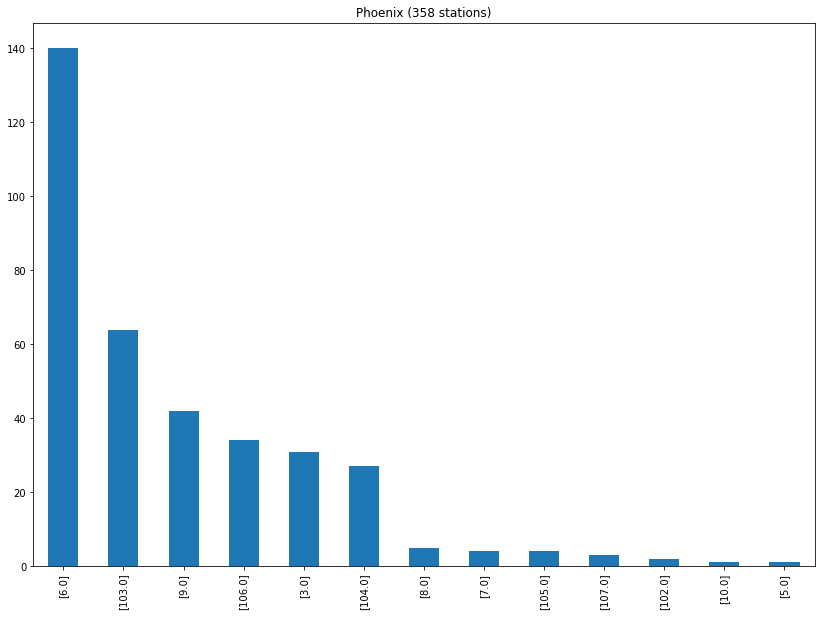

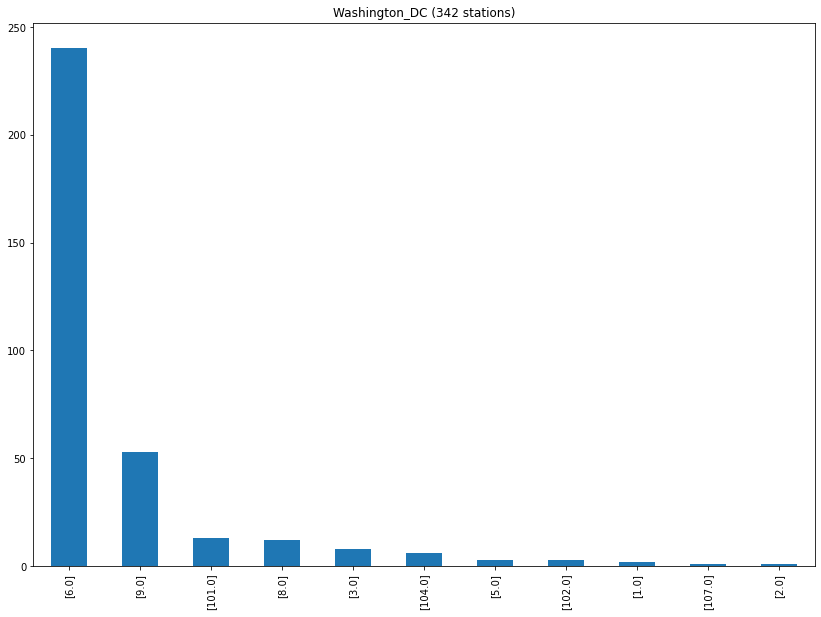

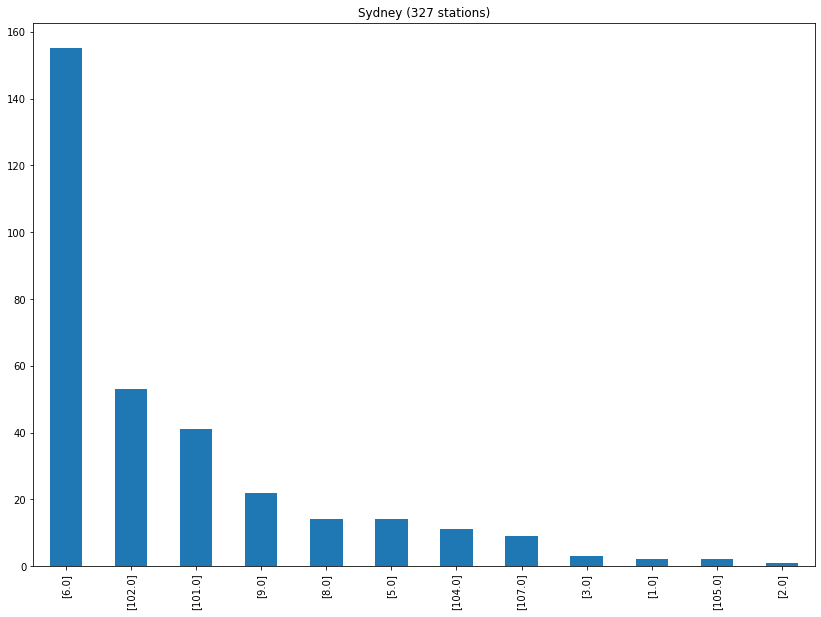

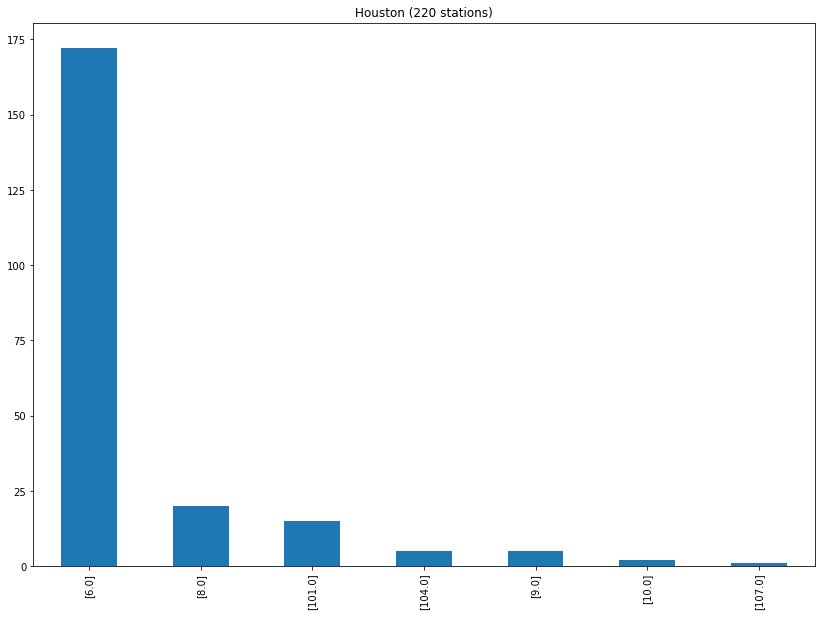

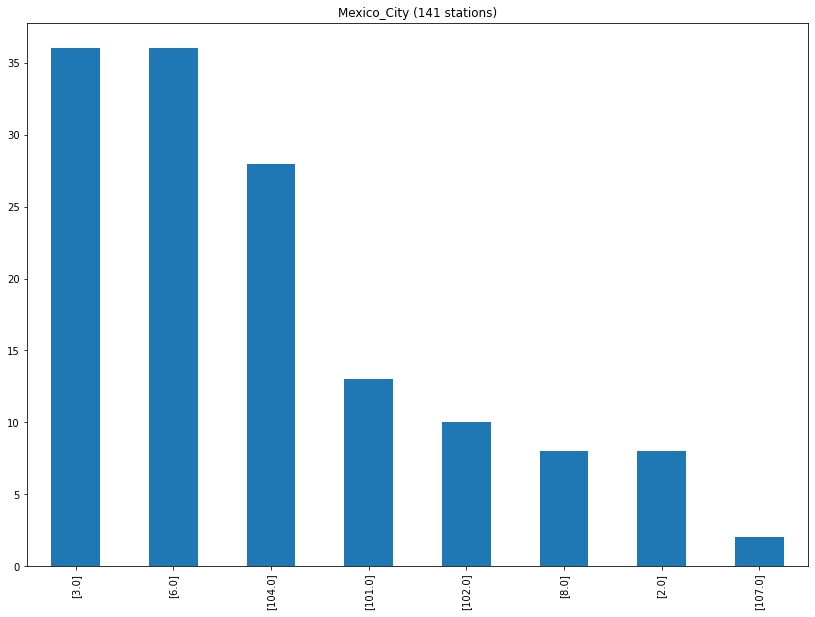

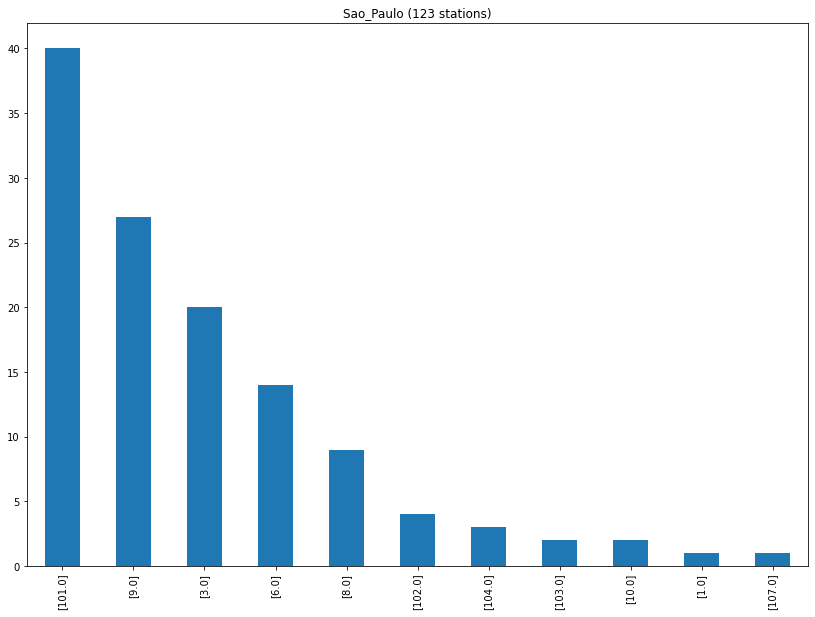

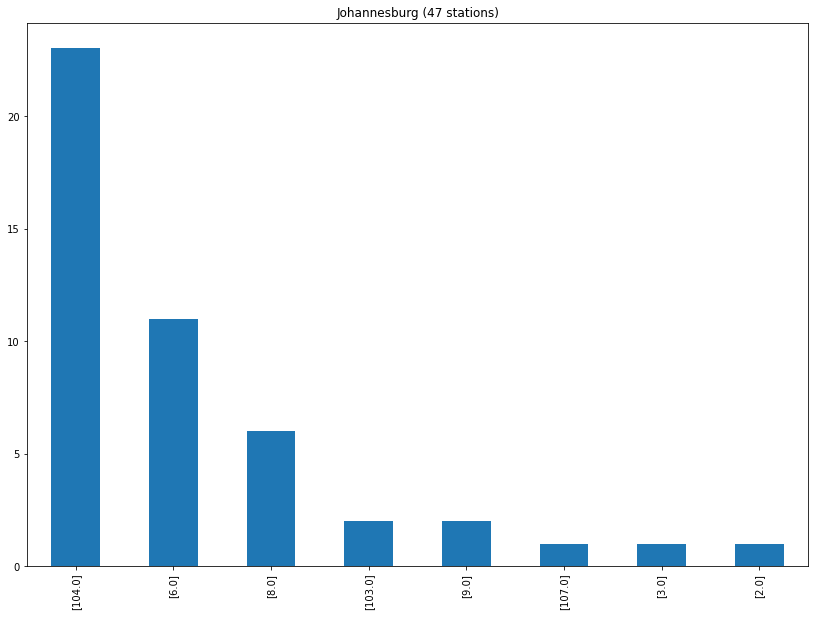

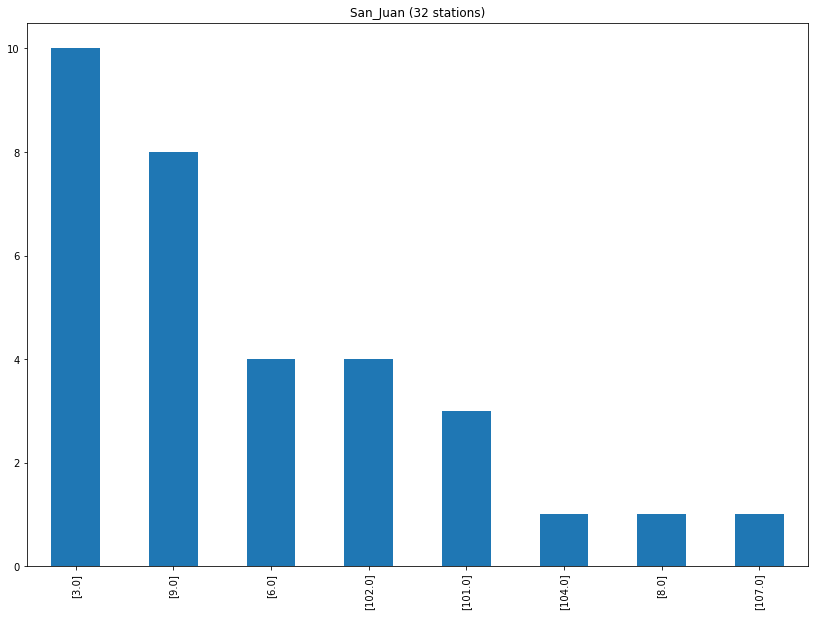

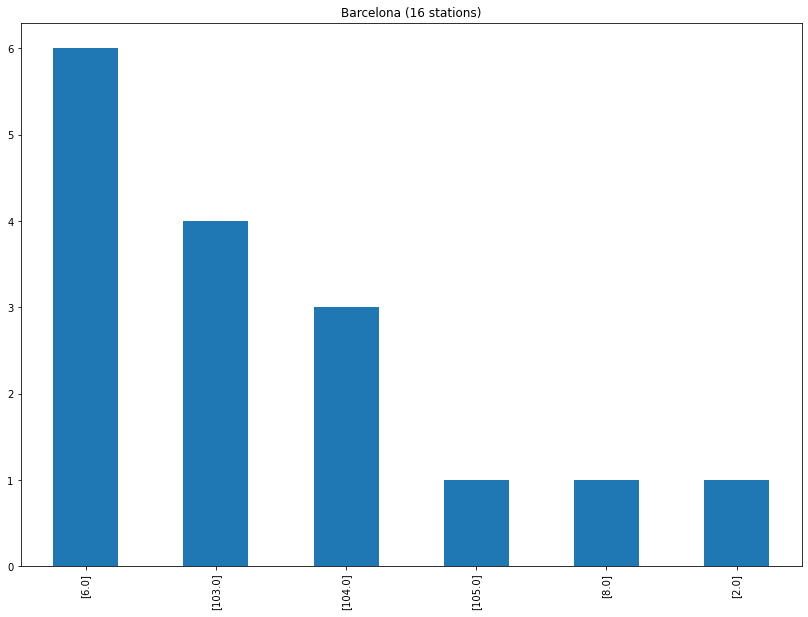

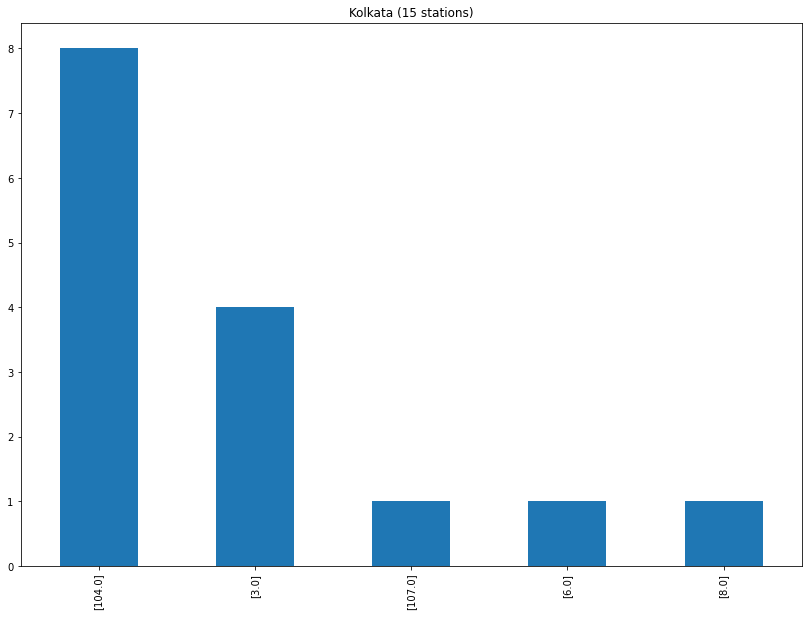

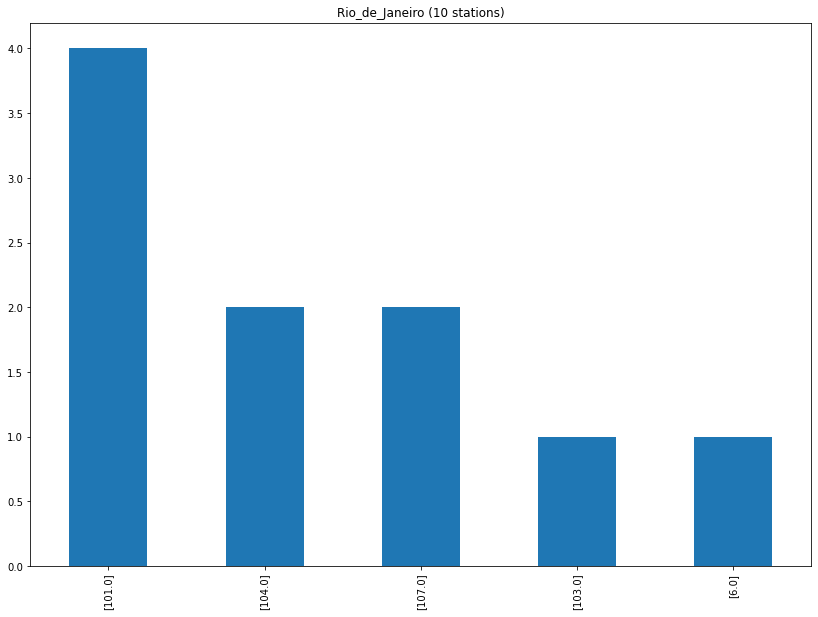

In [37]:
for c, v in zip(counts.index, counts):
    # only plot cities with at least 10 stations:
    if v > 9:
        ax = stations[stations['city'] == c]['lcz'].value_counts().plot(kind='bar', title=c+' ('+str(v)+' stations)')
        plt.show(ax)

How big is the population for each of those cities wihin the LCZ classified areas? Before running the next block of code, make sure to run the [_vectorize_wudapt.sh](Cities_raster/cities_moll/_vectorize_wudapt.sh) shell script. It will turn the WUDAPT raster for each of the above cities into a single polygon with the area classified (excluding any nodata areas), stored as a geopackage. We will use these geopackages to generate some zonal statistics with the [rasterstats](https://pythonhosted.org/rasterstats/index.html) module now, namely the sum of population within the polygon according to GHSL 

In [38]:
for c, v in zip(counts.index, counts):
    # only plot cities with at least 10 stations:
    if v > 9:
        stats = zonal_stats("Cities_raster/cities_moll/"+c+".flat.gpkg", 
            "GHS_POP_GPW42015_GLOBE_R2015A_54009_250_v1_0/GHS_POP_GPW42015_GLOBE_R2015A_54009_250_v1_0.tif",
            stats="sum")
        
        print(c,stats[len(stats)-1]['sum'])

Phoenix 4563880.0
Washington_DC 5651566.0
Sydney 4467671.5
Houston 5727922.0
Mexico_City 21686864.0
Sao_Paulo 22042668.0
Johannesburg 12265840.0
San_Juan 1447428.375
Barcelona 4808705.5
Kolkata 23701058.0
Rio_de_Janeiro 12915293.0


Next, I'd like to know the distribution of 2015 GHSL population at our stations for each city by LCZ. First, we'll make a dictionary [mapping the LCZ codes to the names](https://journals.ametsoc.org/view-large/9514426) to label the plots properly later:

In [55]:
LCZs = dict({'[1.0]': 'Compact high-rise',
            '[2.0]': 'Compact midrise',
            '[3.0]': 'Compact low-rise',
            '[4.0]': 'Open high-rise',
            '[5.0]': 'Open midrise',
            '[6.0]': 'Open lowrise',
            '[7.0]': 'Lightweight low-rise',
            '[8.0]': 'Large low-rise',
            '[9.0]': 'Sparsely built',
            '[10.0]': 'Heavy industry',
            '[101.0]': 'Dense trees',
            '[102.0]': 'Scattered trees',
            '[103.0]': 'Bush, scrub',
            '[104.0]': 'Low plants',
            '[105.0]': 'Bare rock or paved',
            '[106.0]': 'Bare soil or sand',
            '[107.0]': 'Water' })
LCZs

{'[1.0]': 'Compact high-rise',
 '[2.0]': 'Compact midrise',
 '[3.0]': 'Compact low-rise',
 '[4.0]': 'Open high-rise',
 '[5.0]': 'Open midrise',
 '[6.0]': 'Open lowrise',
 '[7.0]': 'Lightweight low-rise',
 '[8.0]': 'Large low-rise',
 '[9.0]': 'Sparsely built',
 '[10.0]': 'Heavy industry',
 '[101.0]': 'Dense trees',
 '[102.0]': 'Scattered trees',
 '[103.0]': 'Bush, scrub',
 '[104.0]': 'Low plants',
 '[105.0]': 'Bare rock or paved',
 '[106.0]': 'Bare soil or sand',
 '[107.0]': 'Water'}

Let's make some box plots: 

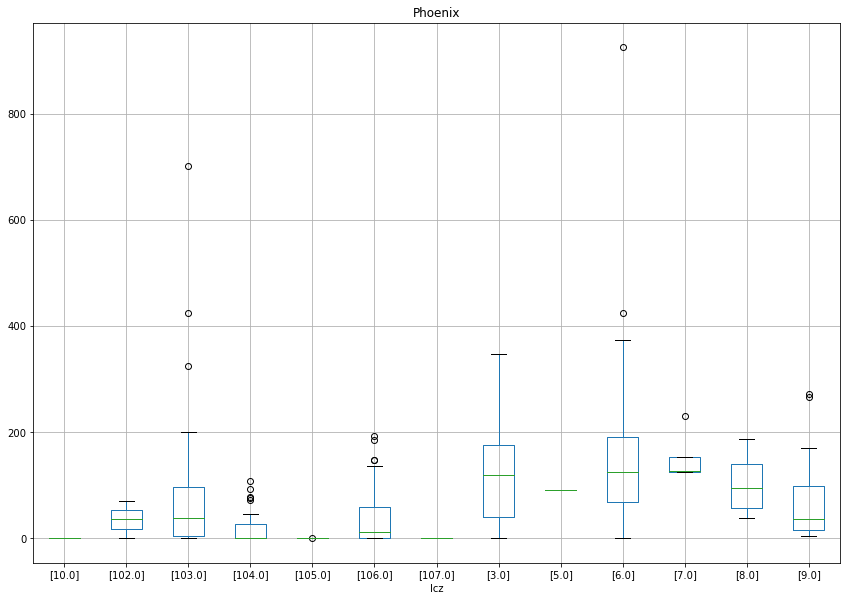

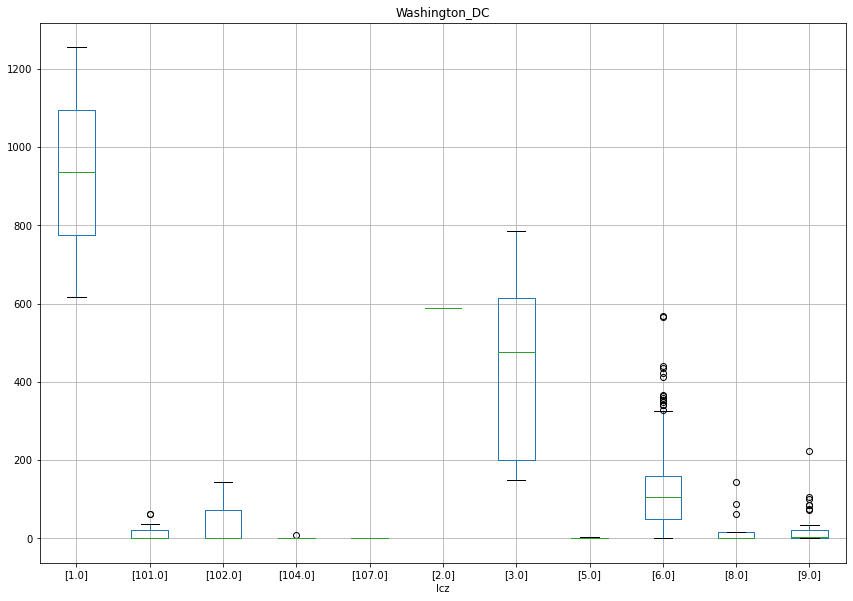

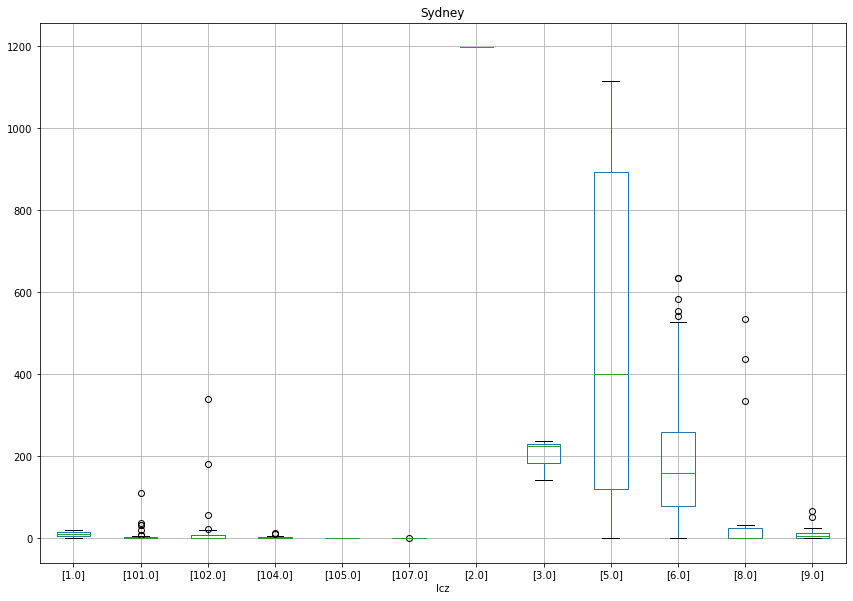

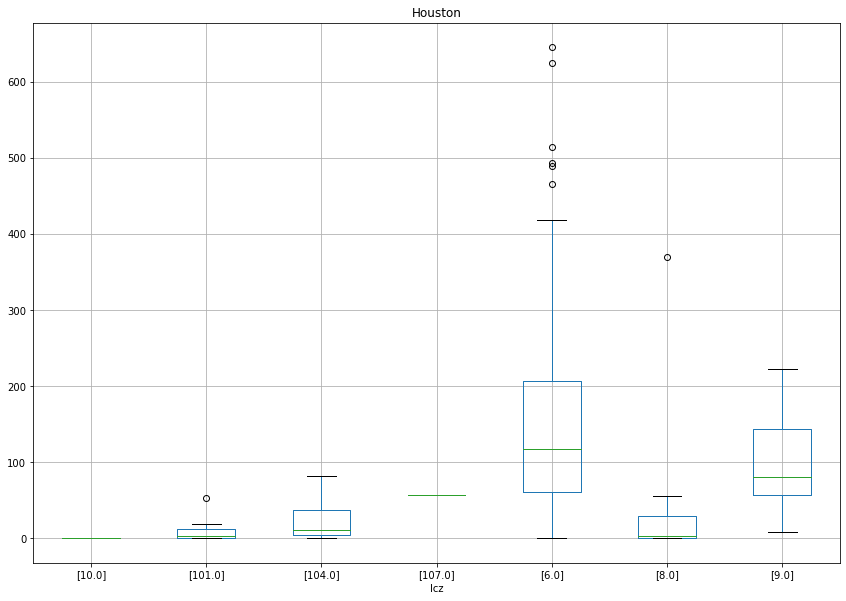

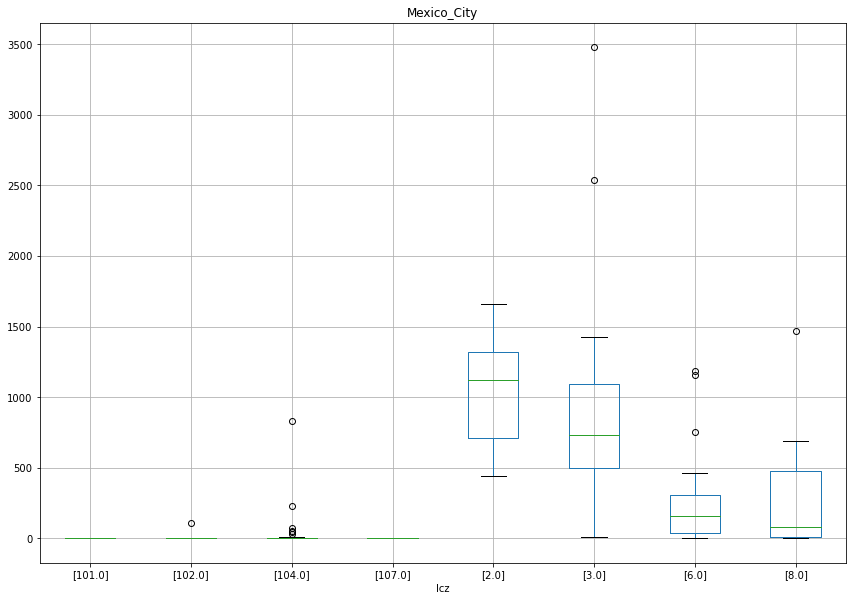

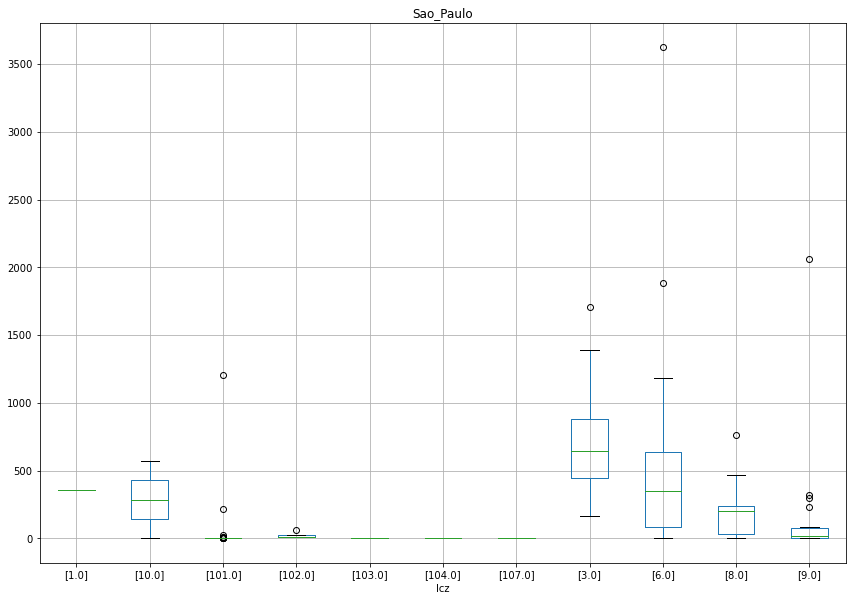

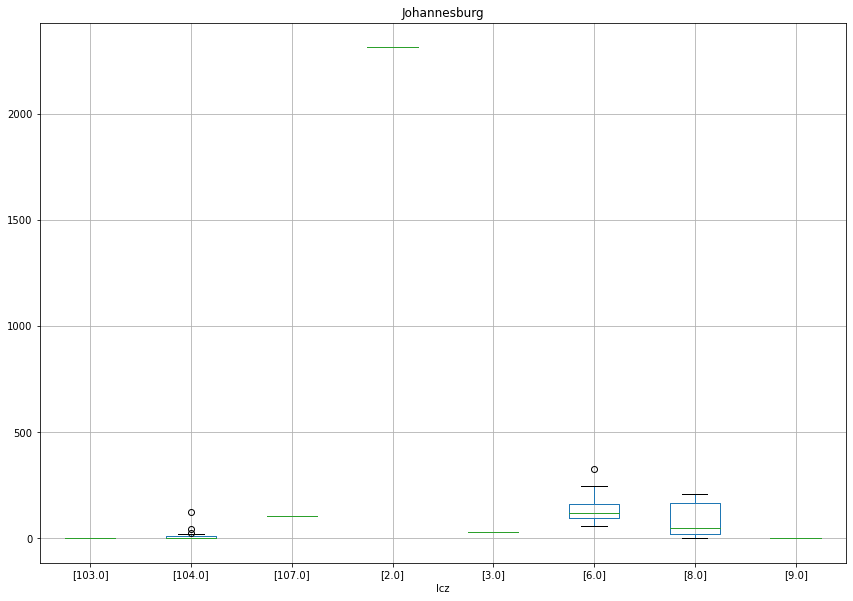

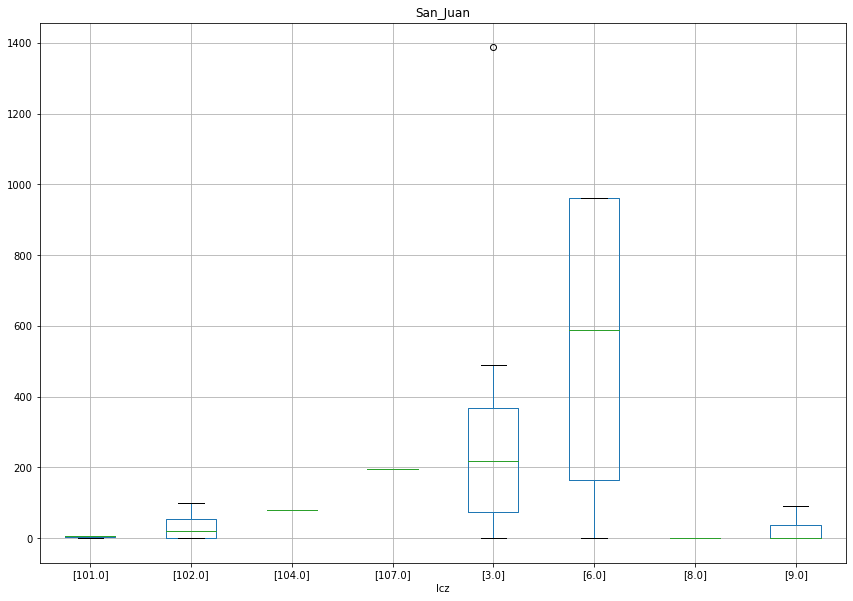

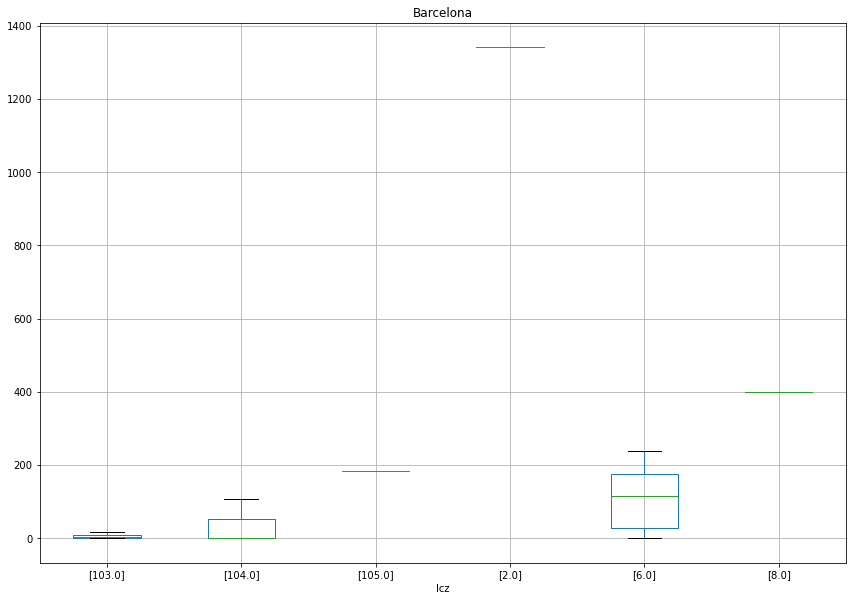

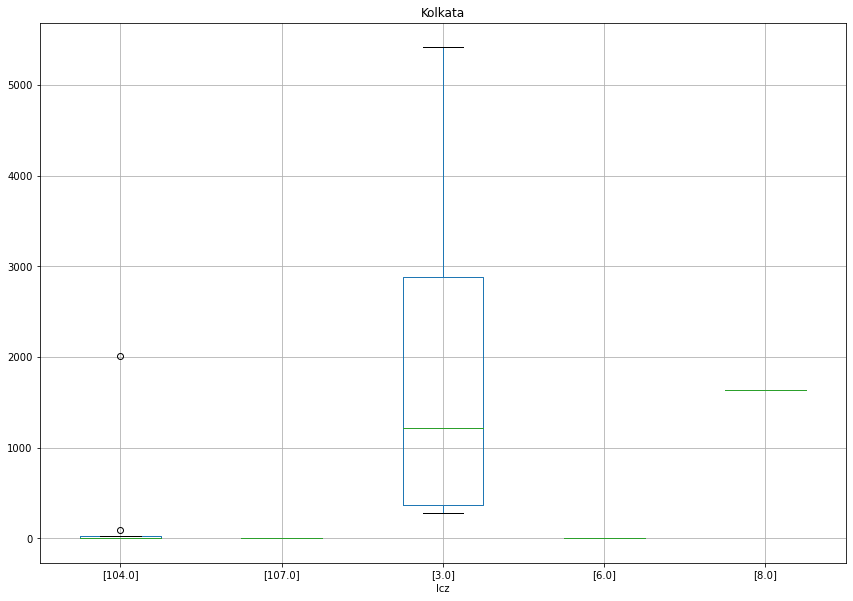

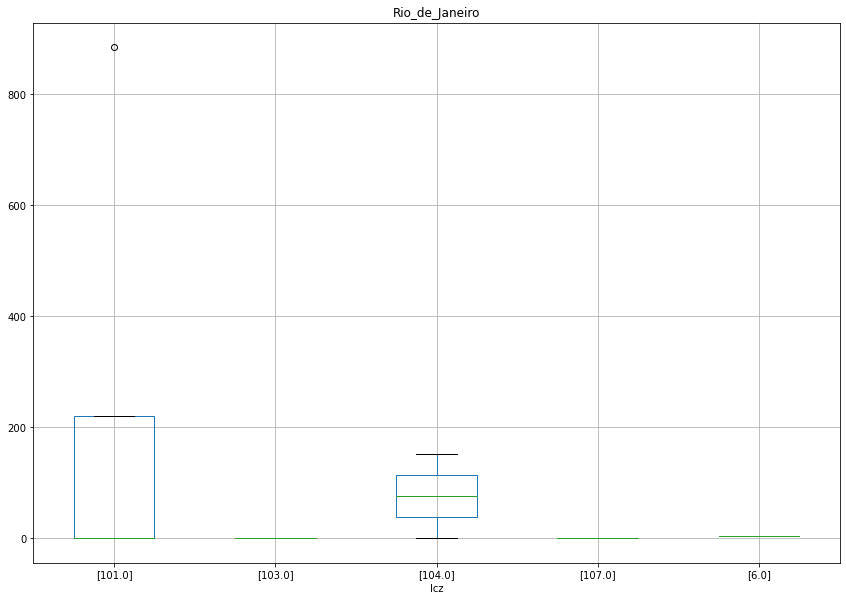

In [57]:
for c, v in zip(counts.index, counts):
    # only plot cities with at least 10 stations:
    if v > 9:
        ax = stations[stations['city'] == c].boxplot(column = 'pop2015', by='lcz')
            # change title:
        plt.title(c)
        plt.suptitle('')

        plt.show(ax)

Let's look at that the other way around: One plot per LCZ, with separate boxes for each city, so we can see whether the different LCZs have simmilar population densities in the different cities:

*This is including all WUDAPT cities for now, not just the 11 we have above.*

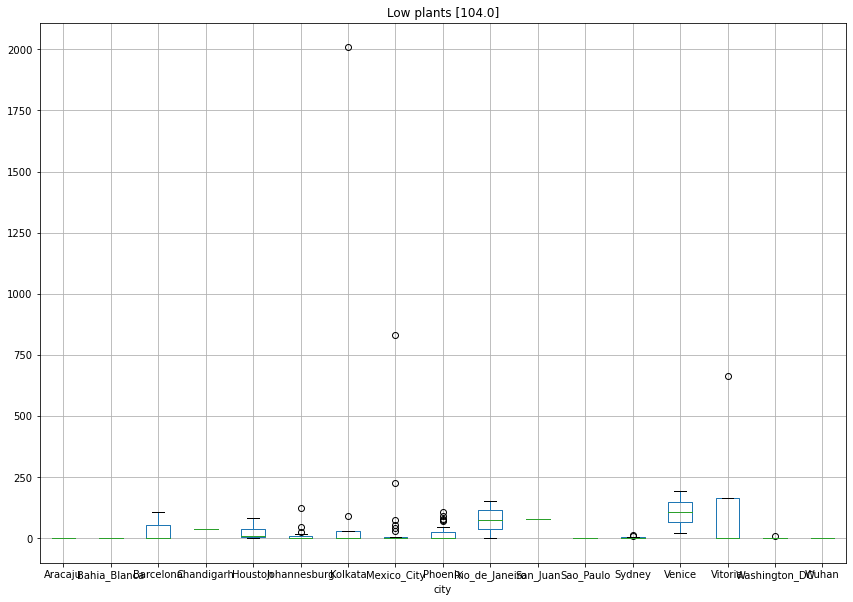

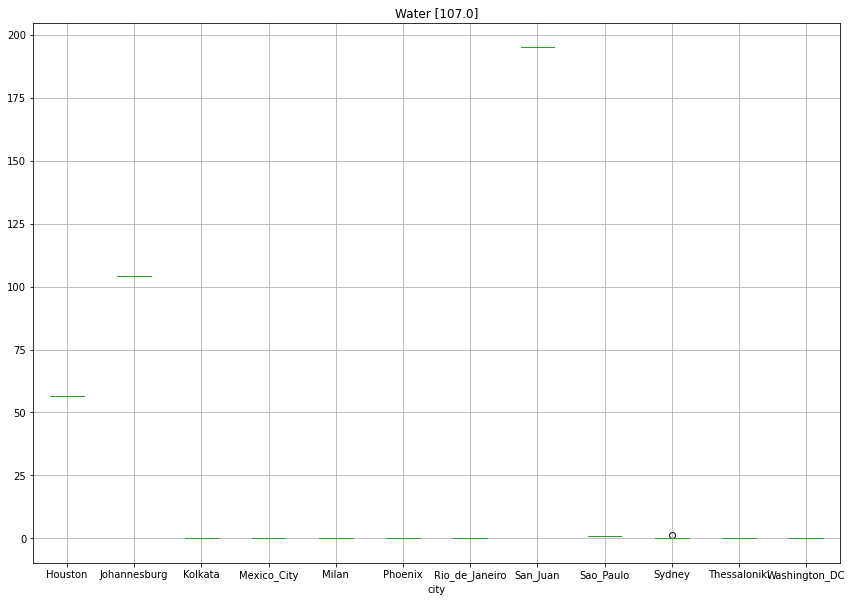

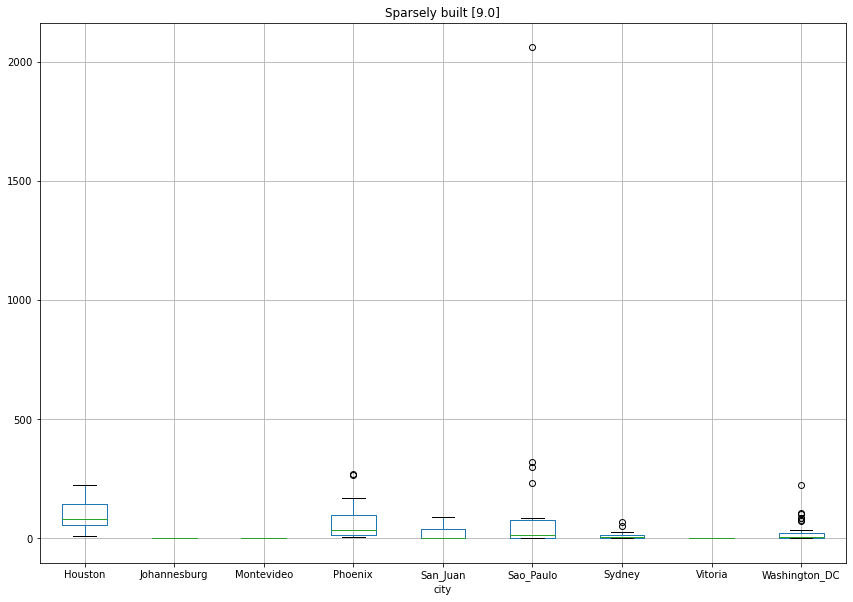

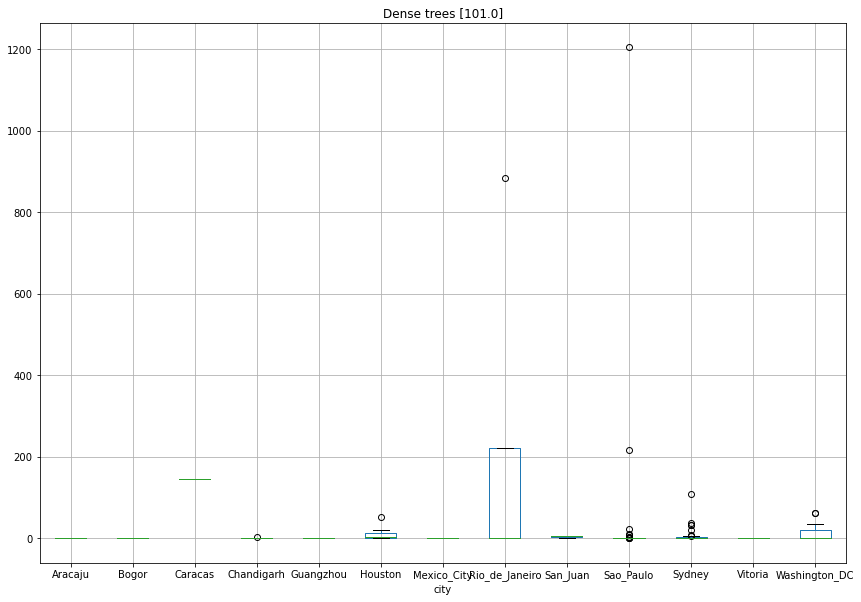

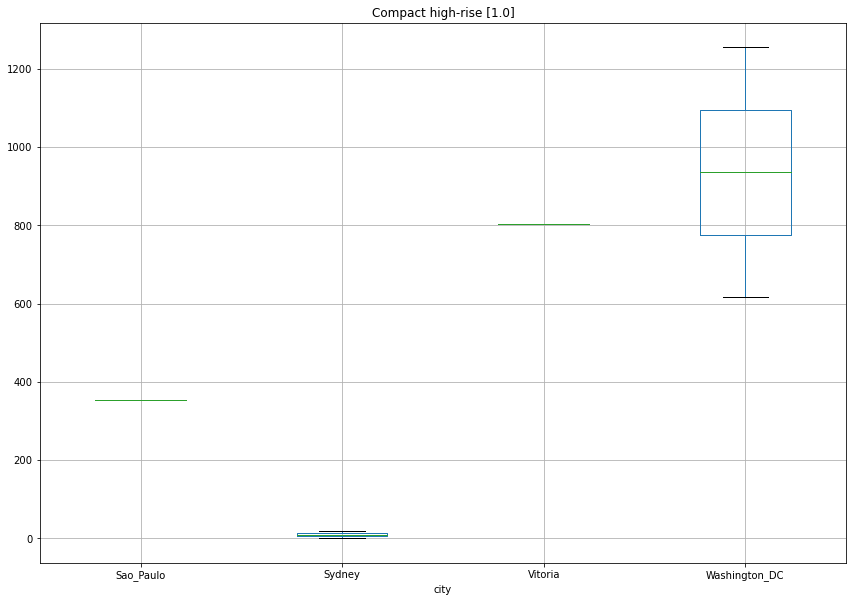

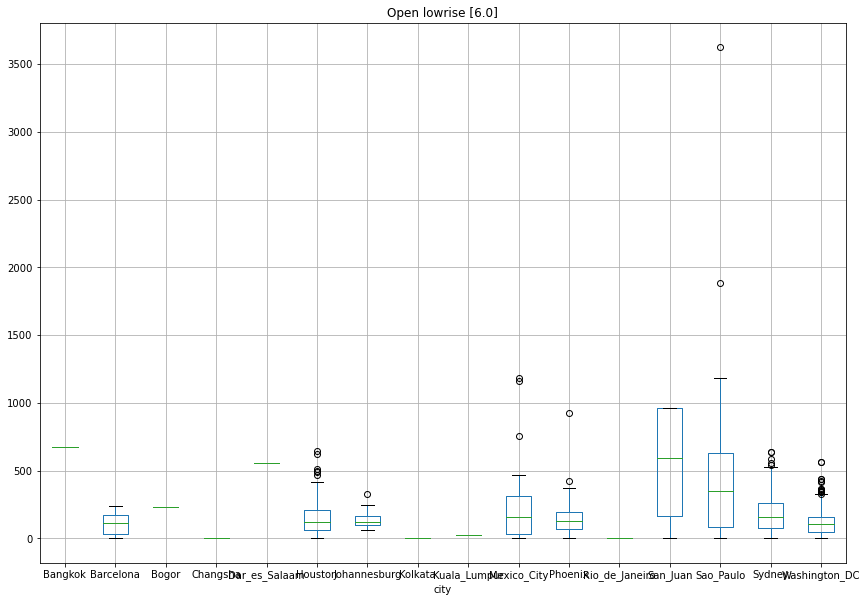

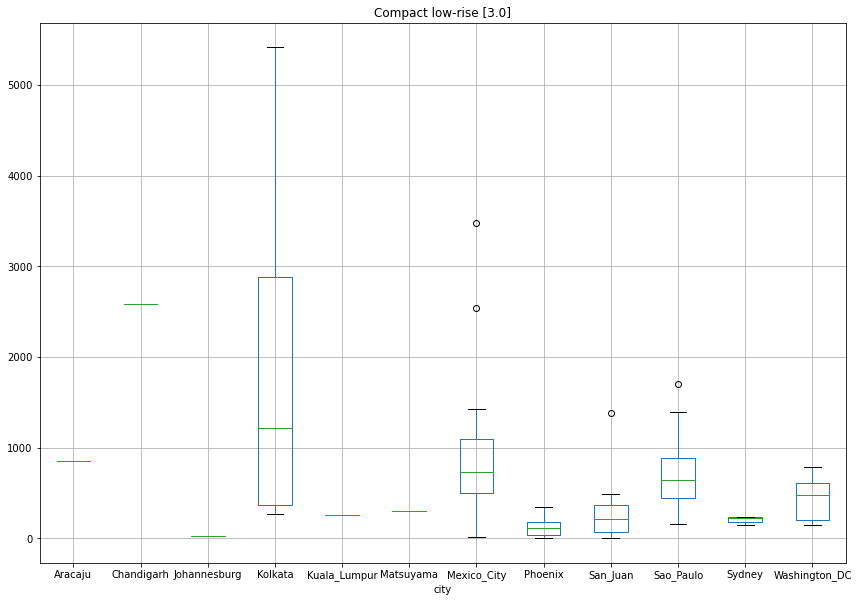

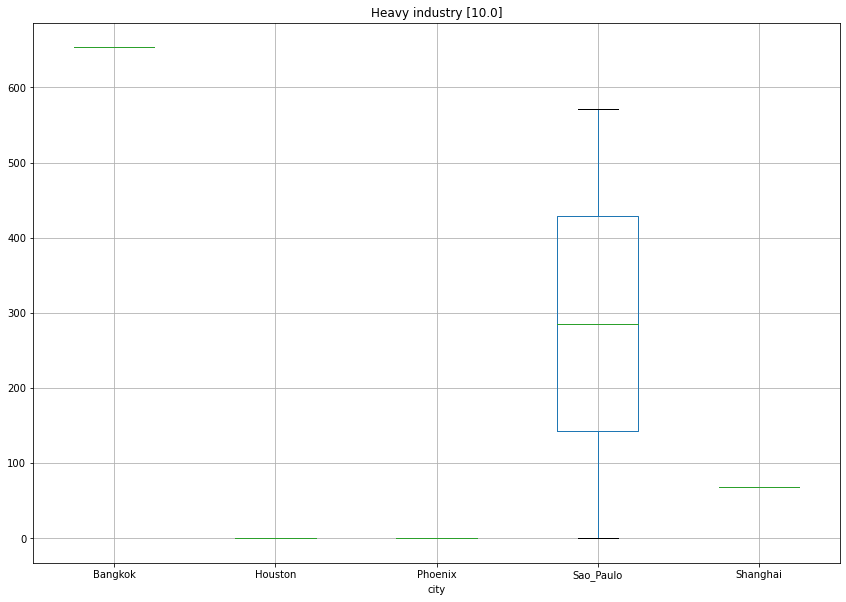

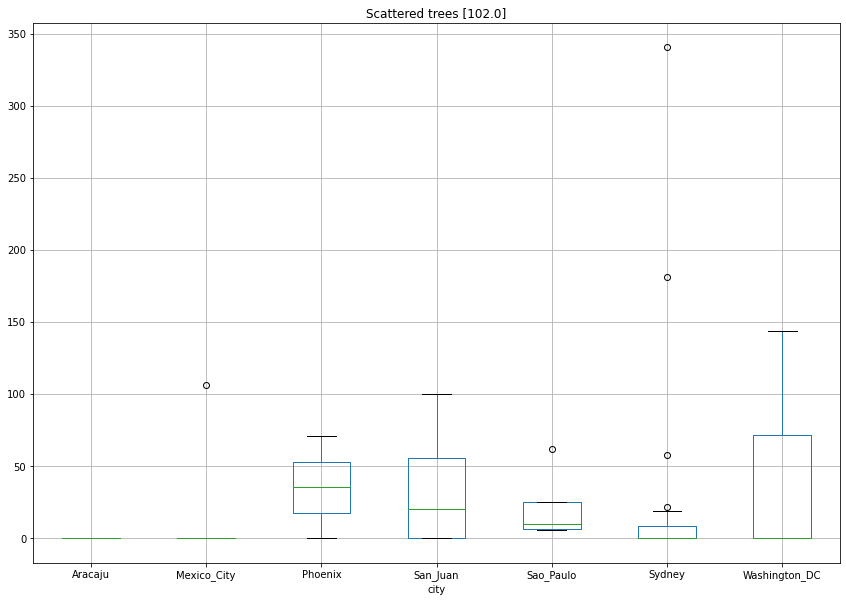

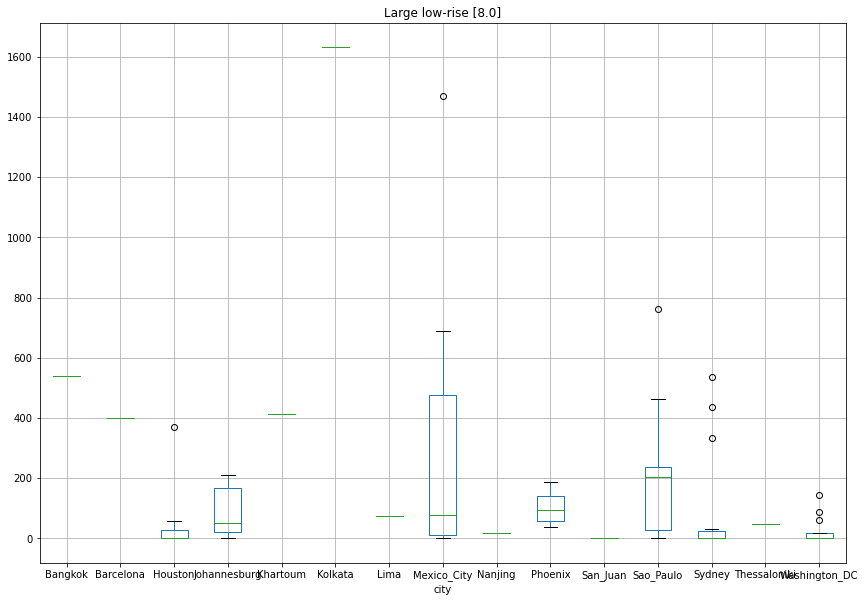

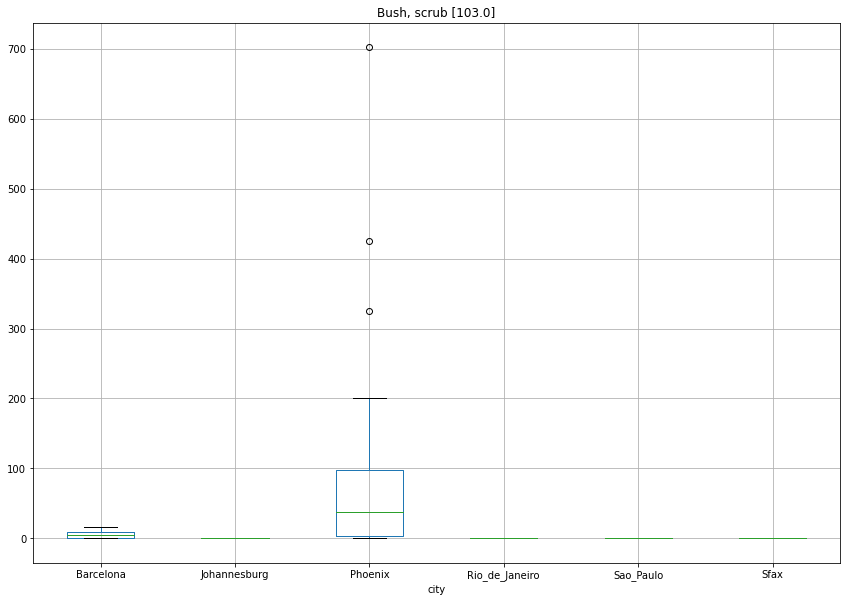

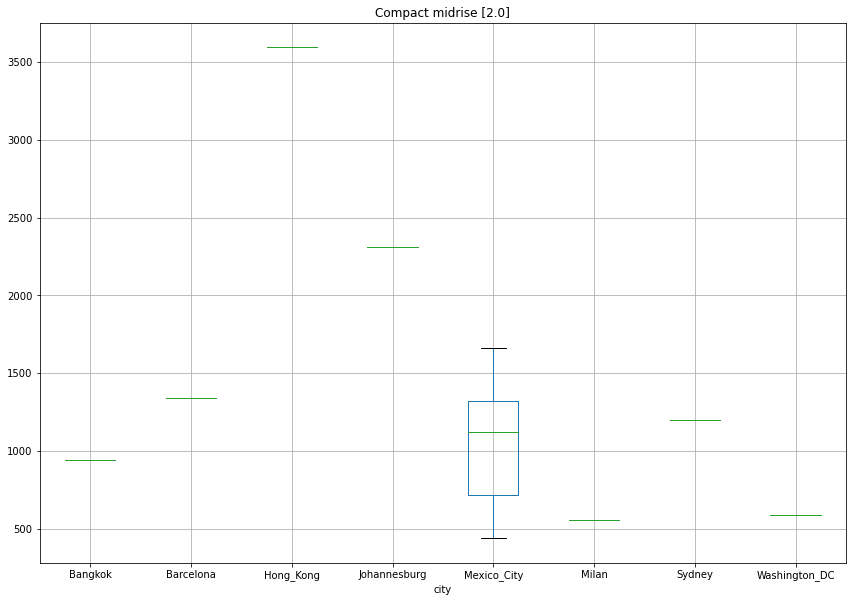

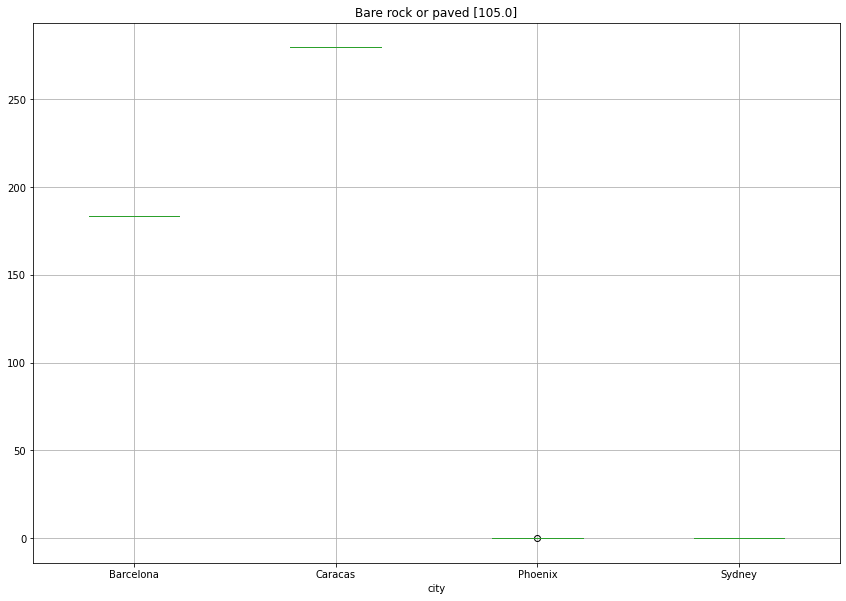

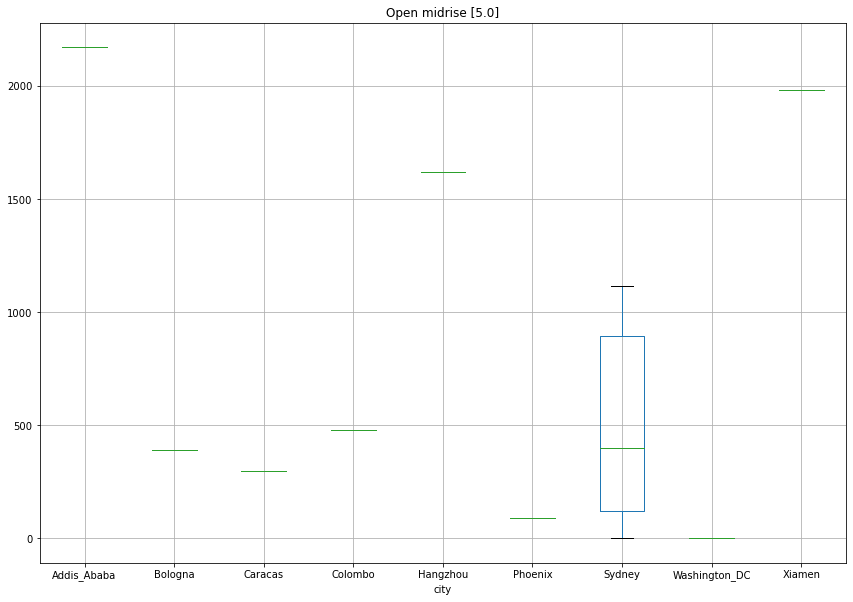

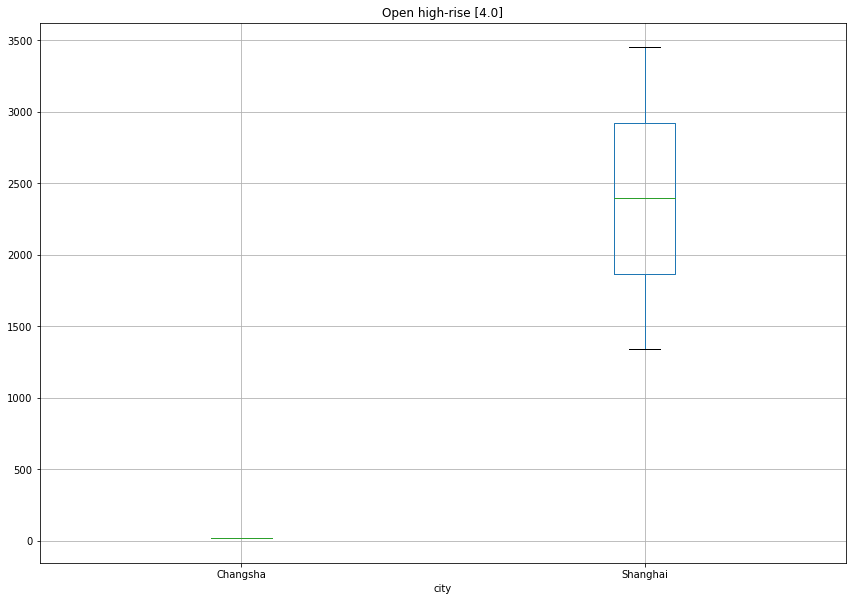

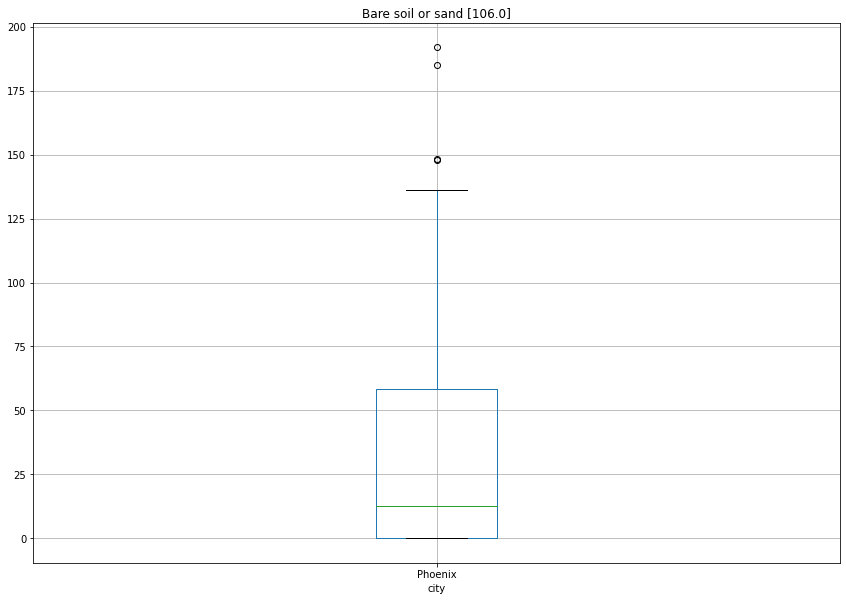

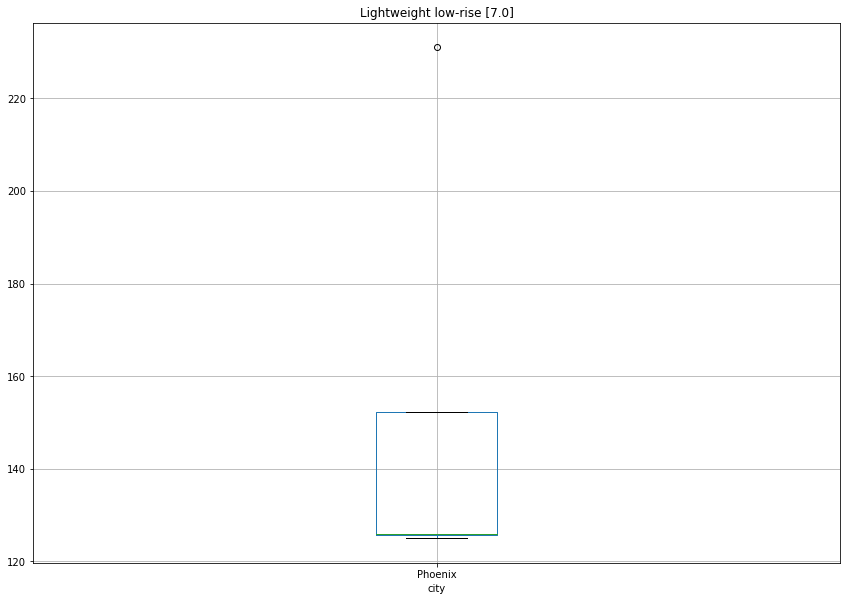

In [58]:
for l in stations['lcz'].unique(): # for each climate zone:
    ax = stations[stations['lcz'] == l].boxplot(column = 'pop2015', by='city')
    
    # change title:
    plt.title(LCZs[l] + ' ' + l)
    plt.suptitle('')
        
    # show
    plt.show(ax)

![](https://thumbs.gfycat.com/HandmadeHonorableBluebreastedkookaburra-size_restricted.gif)

That should be all for now. ```stations_complete.csv``` will be used in the further analysis. 

### 👉 head over to [2_Analysis_2015.ipynb](2_Analysis_2015.ipynb) to continue.